参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Wed Nov 23 00:30:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0 Off |                  N/A |
| 70%   51C    P8    54W / 350W |   1920MiB / 24268MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
model_cls = "CustomModel"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

#MODEL_NAME = ""
#MODEL_NAME = "tf_efficientnetv2_b1"
MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
cfg_prob_sample_mixup = 0.5

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

add_name = ""

In [4]:
# Parameters
add_name = "_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma"
MODEL_NAME = "tf_efficientnet_b5_ap"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma"
cfg_apex = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
is_trn_allfold = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"3090_kqi_ex066_public{add_name}"
print(NAME)

3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 400件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX004_SIGNAL = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_1"  # SSD 400件
    EX005_SIGNAL_ISO1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap_iso800"  # SSD 800件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

/volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")
print("test_df.shape:", test_df.shape)
#display(test_df)

train_df.shape: (600, 21)
test_df.shape: (7975, 19)


In [11]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]

        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)

add_df_all.shape: (8400, 9)


In [12]:
#=====

In [13]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [14]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p


# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
        
    return img

# Quick EDA

In [15]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma
/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/train/02887d232.hdf5
img.max(), img.min(): 0.9802907 -0.19574381
img.shape: (2, 360, 127)
y: 1


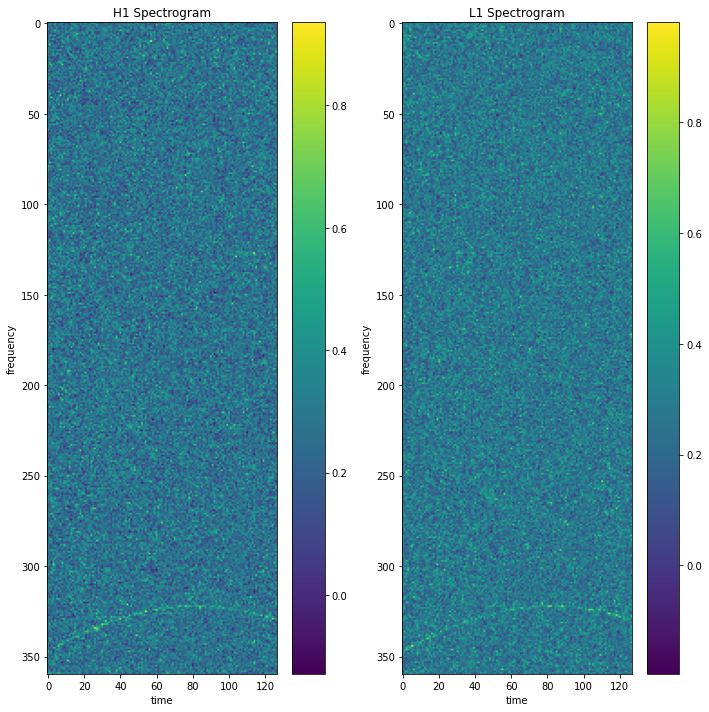

[[[0.35834372 0.1746685  0.33968183 ... 0.2677436  0.13339844 0.3835639 ]
  [0.2406027  0.42191827 0.23059696 ... 0.25745985 0.21757542 0.18510742]
  [0.11603875 0.25921786 0.2768124  ... 0.3191976  0.30033907 0.1881646 ]
  ...
  [0.29268605 0.3245816  0.02045508 ... 0.0864502  0.19288194 0.28483072]
  [0.36728254 0.38535064 0.14893036 ... 0.4037896  0.3231988  0.07379015]
  [0.53413427 0.48057327 0.4670277  ... 0.2746121  0.34705675 0.31653917]]

 [[0.14572474 0.2650934  0.16885151 ... 0.28198785 0.23488498 0.24016385]
  [0.5215323  0.26583654 0.448552   ... 0.52761775 0.29946017 0.31322157]
  [0.20223762 0.26337212 0.4841211  ... 0.19272733 0.4385715  0.3103407 ]
  ...
  [0.16557358 0.22353901 0.09281849 ... 0.20139703 0.26048177 0.21162923]
  [0.08281923 0.3719503  0.59807014 ... 0.39294976 0.10794    0.42657062]
  [0.17728308 0.33130813 0.24057066 ... 0.24026965 0.38095975 0.36697862]]]

/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5
im

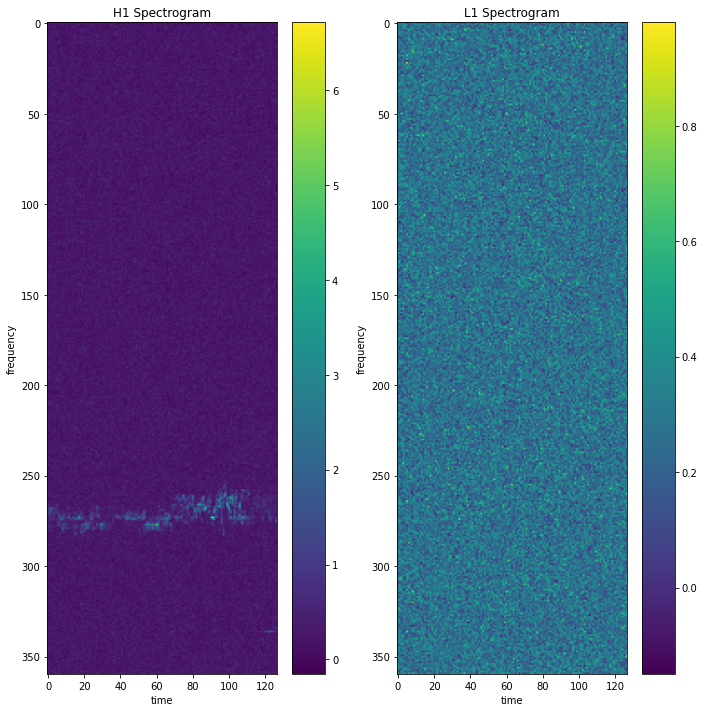

[[[0.30795237 0.3739912  0.43819636 ... 0.29906955 0.36730957 0.13462728]
  [0.2133699  0.09840368 0.19725908 ... 0.10837945 0.45844457 0.45521376]
  [0.21546865 0.3655616  0.21526206 ... 0.3076199  0.18852268 0.36734754]
  ...
  [0.2775946  0.23926273 0.27291852 ... 0.2803928  0.18194987 0.19542101]
  [0.2954313  0.4358154  0.48035744 ... 0.31773818 0.48006728 0.3455946 ]
  [0.15380085 0.2212192  0.17246933 ... 0.30250108 0.6534017  0.18005371]]

 [[0.43900135 0.36443698 0.21497175 ... 0.13948838 0.18343912 0.40506727]
  [0.36402863 0.30859897 0.32143208 ... 0.48650444 0.29630262 0.37631294]
  [0.43365136 0.16476801 0.21735628 ... 0.1567437  0.2313151  0.16938747]
  ...
  [0.17040645 0.18656886 0.13501091 ... 0.4562093  0.30369467 0.04014215]
  [0.14696096 0.07875207 0.49599996 ... 0.33040908 0.506703   0.162245  ]
  [0.3311324  0.2794337  0.3432356  ... 0.37291667 0.23391928 0.22572428]]]


In [16]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[806]["path"]
if "/kqi/output" in os.getcwd():
    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
else:
    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [17]:
#%debug

In [18]:
#=====

# To npy

In [19]:
#!rm -r {NPY_DIR}/{normalize_type}

In [20]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB:
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)
        print(add_df_all["path"].iloc[0])  # パス確認

INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/train
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [16:27<00:00,  1.23s/it]


INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/ex006_generating_noise_gap1400
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/ex006_generating_signal_gap800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [16:31<00:00,  1.24s/it]

/volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/train/001121a05.npy
/volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/test/00054c878.npy
/volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma/ex003_generating_noise_2_gap/0_sqrtSX1.4e-22_F0328.56_gap.npy


In [21]:
#=====

# Libraries

In [22]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.11
device: cuda
torch: 1.13.0+cu117


In [23]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [24]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [25]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [26]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # dataset内のmixupの確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        
        # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    #CFG.print_freq=10
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 50,
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 16,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'epochs': 50,
 'freq': 360,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha': 1.0,
 'mixup_off_epoch': 0,
 'model_cls': 'CustomModel',
 'model_name': 'tf_efficientnet_b5_ap',
 'n_fold': 5,
 'name': '3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma',
 'norm_type': 'largekernel|p-robustscaler|ts-ma',
 'num_classes': 1,
 'num_workers': 8,
 'optimizer': 'adamw',
 'pretrained': True,
 'print_fre

# Utils

In [27]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [28]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [29]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.orig_flags = train['freq min'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        self.train0 = train[train["target"] == 0]   # label=0のdf
        
        self.train0_orig = self.train0.dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label == 0) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label == 0) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label == 0) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label == 0) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label == 0) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label == 0:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] == 1:
                label = torch.tensor(1).float()
            #print("sample_mixup")
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnanaならadd_data
                if label == 0:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 128 == 0):
                # step%128=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label == 0:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label

# Transform

In [30]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [31]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15])


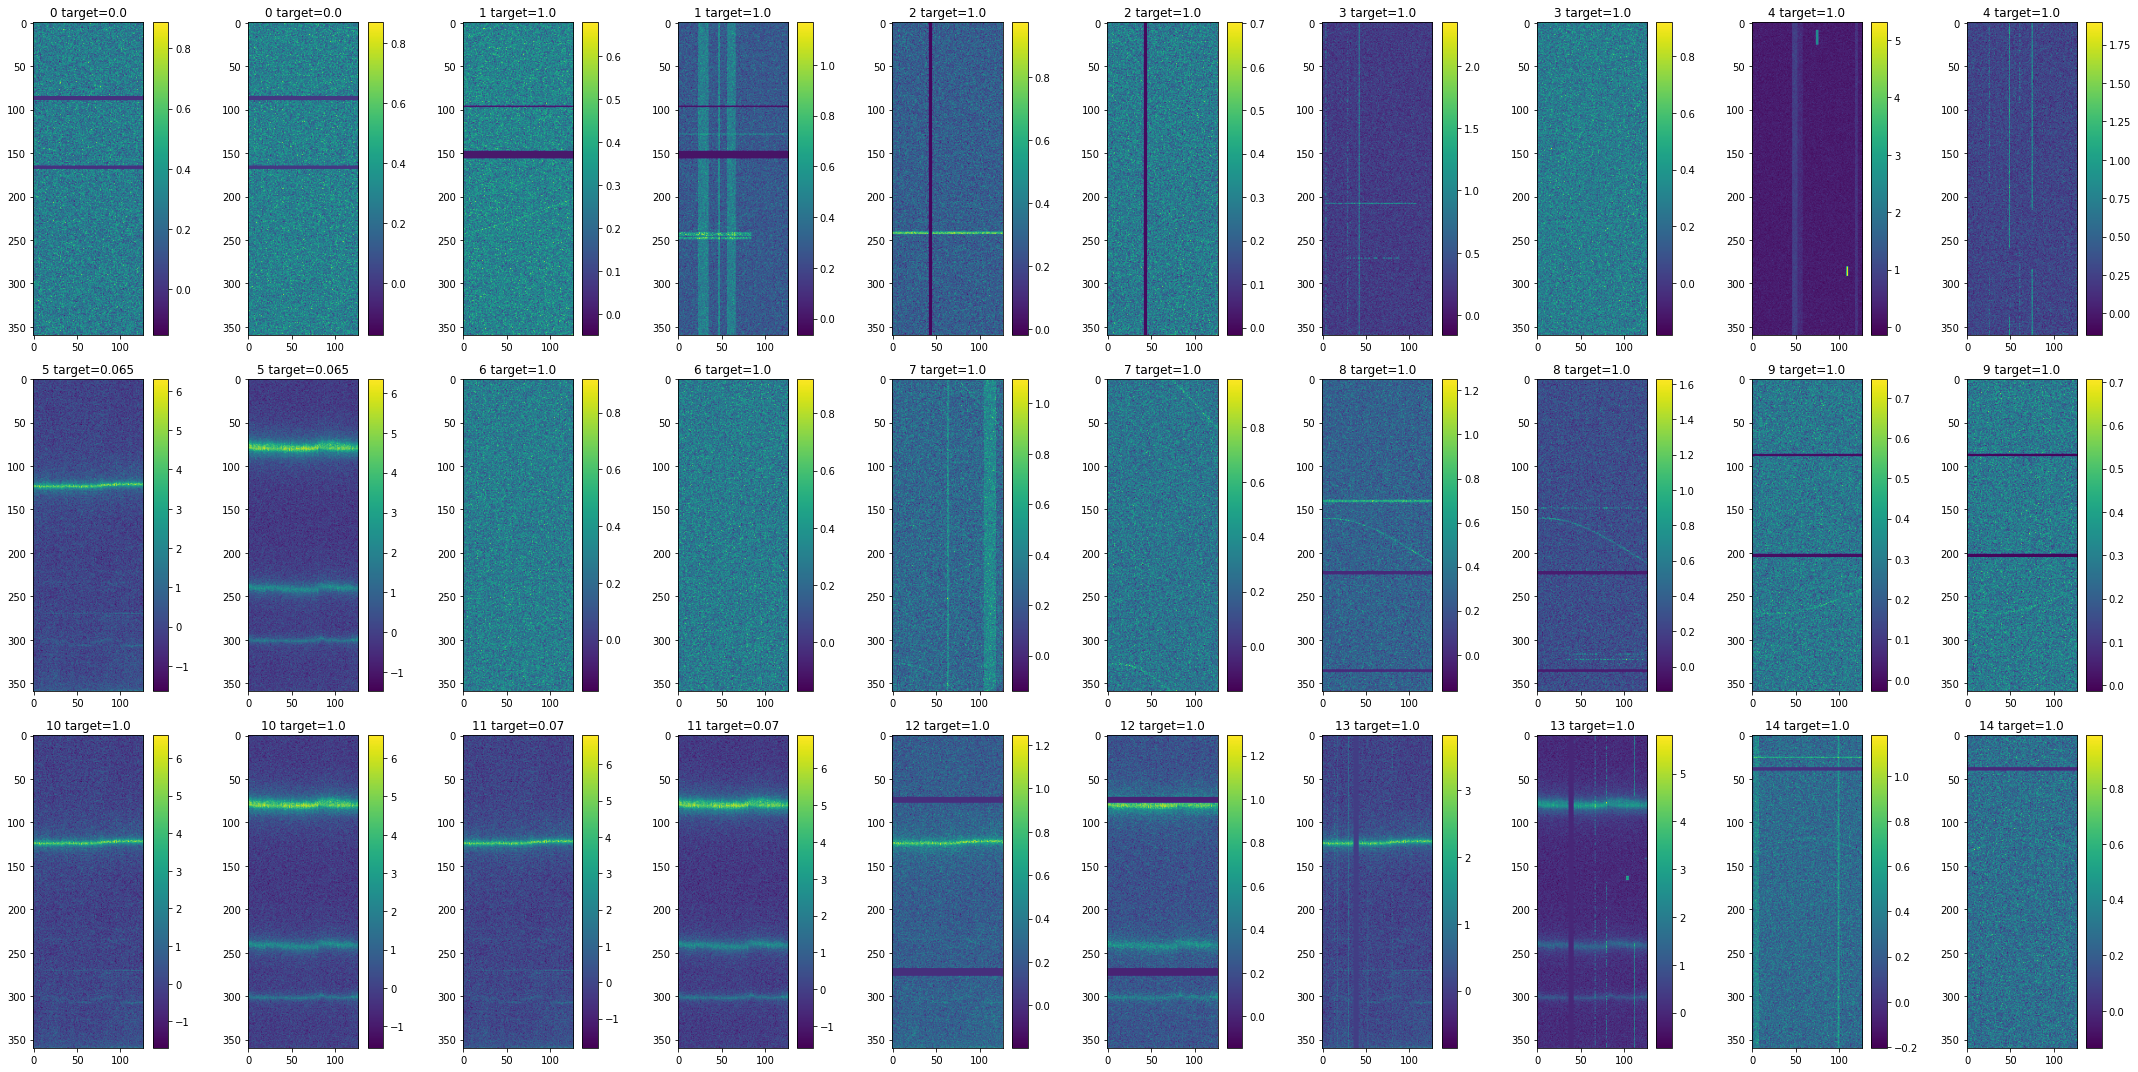

In [32]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels) in enumerate(train_loader):
    print(images.shape, labels.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la) in enumerate(zip(images, labels)):
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [33]:
#=====

# Model

In [34]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [35]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [36]:
#=====

In [37]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [38]:
#=====

In [39]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [40]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [41]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [42]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step):
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs = model(x.float())
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs = model(x.float())
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs = model(images, labels)  # 予測値の算出
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs = model(images, labels)  # 予測値の算出
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [43]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step)
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step)
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step)
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [44]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            outputs = model(images, labels)  # logit
        loss = criterion(outputs, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [45]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)

    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [46]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 9)
folds.shape: (9000, 28)
========== fold: 0, seed: 0 training ==========


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64
Epoch: [1][0/450] Elapsed 0m 2s (remain 18m 19s) Loss: 1.5009(1.5009) Grad: nan  LR: 4.0000e-06  
Epoch: [1][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3425(1.6847) Grad: 73713.0000  LR: 4.0000e-06  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 2.0955(2.0955) 


Epoch 1 - avg_train_loss: 1.6847  avg_val_loss: 1.6006  time: 99s
Epoch 1 - Score: 0.6050
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6050 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.8849(1.6006) 


Epoch 1 - Save Best Loss: 1.6006 Model


Epoch: [2][0/450] Elapsed 0m 0s (remain 7m 8s) Loss: 1.5366(1.5366) Grad: nan  LR: 1.3600e-04  
Epoch: [2][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.8060(1.1627) Grad: 29719.8770  LR: 1.3600e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 33s) Loss: 0.8260(0.8260) 


Epoch 2 - avg_train_loss: 1.1627  avg_val_loss: 0.6234  time: 98s
Epoch 2 - Score: 0.7000
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7000 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0066(0.6234) 


Epoch 2 - Save Best Loss: 0.6234 Model


Epoch: [3][0/450] Elapsed 0m 0s (remain 6m 2s) Loss: 0.5767(0.5767) Grad: inf  LR: 2.6800e-04  
Epoch: [3][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.4500(0.6021) Grad: 22704.3027  LR: 2.6800e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 33s) Loss: 0.4781(0.4781) 


Epoch 3 - avg_train_loss: 0.6021  avg_val_loss: 0.6153  time: 98s
Epoch 3 - Score: 0.7493
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7493 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2976(0.6153) 


Epoch 3 - Save Best Loss: 0.6153 Model


Epoch: [4][0/450] Elapsed 0m 1s (remain 9m 12s) Loss: 0.5248(0.5248) Grad: 191855.2344  LR: 4.0000e-04  
Epoch: [4][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.5993(0.5763) Grad: 14770.9609  LR: 4.0000e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 32s) Loss: 0.4643(0.4643) 


Epoch 4 - avg_train_loss: 0.5763  avg_val_loss: 0.5084  time: 98s
Epoch 4 - Score: 0.7852
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7852 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3292(0.5084) 


Epoch 4 - Save Best Loss: 0.5084 Model


Epoch: [5][0/450] Elapsed 0m 1s (remain 10m 5s) Loss: 0.8314(0.8314) Grad: inf  LR: 3.9961e-04  
Epoch: [5][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3801(0.5268) Grad: 7694.3281  LR: 3.9961e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4330(0.4330) 


Epoch 5 - avg_train_loss: 0.5268  avg_val_loss: 0.4933  time: 98s
Epoch 5 - Score: 0.8150
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8150 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2960(0.4933) 


Epoch 5 - Save Best Loss: 0.4933 Model


Epoch: [6][0/450] Elapsed 0m 1s (remain 9m 35s) Loss: 0.3838(0.3838) Grad: 129707.4141  LR: 3.9844e-04  
Epoch: [6][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.7871(0.5089) Grad: 19354.1602  LR: 3.9844e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 32s) Loss: 0.8155(0.8155) 


Epoch 6 - avg_train_loss: 0.5089  avg_val_loss: 1.1359  time: 98s
Epoch 6 - Score: 0.8216
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8216 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0599(1.1359) 
Epoch: [7][0/450] Elapsed 0m 1s (remain 8m 38s) Loss: 0.4286(0.4286) Grad: 71573.2344  LR: 3.9649e-04  
Epoch: [7][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4939(0.5282) Grad: 6806.6416  LR: 3.9649e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 32s) Loss: 0.9995(0.9995) 


Epoch 7 - avg_train_loss: 0.5282  avg_val_loss: 0.6956  time: 99s
Epoch 7 - Score: 0.7918
Epoch 7 - lr: 3.9378e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3856(0.6956) 
Epoch: [8][0/450] Elapsed 0m 1s (remain 9m 16s) Loss: 0.5027(0.5027) Grad: 80446.0000  LR: 3.9378e-04  
Epoch: [8][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2855(0.4895) Grad: 20638.4629  LR: 3.9378e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.5059(0.5059) 


Epoch 8 - avg_train_loss: 0.4895  avg_val_loss: 0.6284  time: 99s
Epoch 8 - Score: 0.6838
Epoch 8 - lr: 3.9031e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3244(0.6284) 
Epoch: [9][0/450] Elapsed 0m 1s (remain 7m 49s) Loss: 0.5248(0.5248) Grad: 151107.7188  LR: 3.9031e-04  
Epoch: [9][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4296(0.4836) Grad: 9919.9160  LR: 3.9031e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4798(0.4798) 


Epoch 9 - avg_train_loss: 0.4836  avg_val_loss: 0.4434  time: 100s
Epoch 9 - Score: 0.8127
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Loss: 0.4434 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4868(0.4434) 
Epoch: [10][0/450] Elapsed 0m 1s (remain 9m 50s) Loss: 0.4952(0.4952) Grad: 88136.0234  LR: 3.8610e-04  
Epoch: [10][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.4697(0.5089) Grad: 21065.2578  LR: 3.8610e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 33s) Loss: 0.7328(0.7328) 


Epoch 10 - avg_train_loss: 0.5089  avg_val_loss: 0.5226  time: 98s
Epoch 10 - Score: 0.7907
Epoch 10 - lr: 3.8116e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8573(0.5226) 
Epoch: [11][0/450] Elapsed 0m 1s (remain 8m 56s) Loss: 0.2193(0.2193) Grad: 34826.9648  LR: 3.8116e-04  
Epoch: [11][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5777(0.4934) Grad: 25720.5039  LR: 3.8116e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.4662(0.4662) 


Epoch 11 - avg_train_loss: 0.4934  avg_val_loss: 0.4466  time: 98s
Epoch 11 - Score: 0.8172
Epoch 11 - lr: 3.7551e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4166(0.4466) 
Epoch: [12][0/450] Elapsed 0m 1s (remain 10m 1s) Loss: 0.5136(0.5136) Grad: 115128.8750  LR: 3.7551e-04  
Epoch: [12][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4851(0.5624) Grad: 2902.0347  LR: 3.7551e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8505(0.8505) 


Epoch 12 - avg_train_loss: 0.5624  avg_val_loss: 0.5920  time: 99s
Epoch 12 - Score: 0.7975
Epoch 12 - lr: 3.6918e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8800(0.5920) 
Epoch: [13][0/450] Elapsed 0m 1s (remain 9m 46s) Loss: 0.5169(0.5169) Grad: 96536.0078  LR: 3.6918e-04  
Epoch: [13][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.9036(0.5148) Grad: 109835.4922  LR: 3.6918e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.4236(0.4236) 


Epoch 13 - avg_train_loss: 0.5148  avg_val_loss: 0.4964  time: 100s
Epoch 13 - Score: 0.8285
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8285 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2088(0.4964) 
Epoch: [14][0/450] Elapsed 0m 1s (remain 9m 34s) Loss: 0.9836(0.9836) Grad: 156558.0938  LR: 3.6219e-04  
Epoch: [14][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3741(0.4845) Grad: 37794.4258  LR: 3.6219e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 33s) Loss: 0.4101(0.4101) 


Epoch 14 - avg_train_loss: 0.4845  avg_val_loss: 0.4504  time: 99s
Epoch 14 - Score: 0.8274
Epoch 14 - lr: 3.5456e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3261(0.4504) 
Epoch: [15][0/450] Elapsed 0m 1s (remain 10m 23s) Loss: 0.4722(0.4722) Grad: 179122.8281  LR: 3.5456e-04  
Epoch: [15][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4287(0.4729) Grad: 5293.1406  LR: 3.5456e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5993(0.5993) 
EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6124(0.4605) 


Epoch 15 - avg_train_loss: 0.4729  avg_val_loss: 0.4605  time: 100s
Epoch 15 - Score: 0.8173
Epoch 15 - lr: 3.4634e-04


Epoch: [16][0/450] Elapsed 0m 1s (remain 12m 19s) Loss: 0.4071(0.4071) Grad: 101998.8750  LR: 3.4634e-04  
Epoch: [16][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3411(0.4722) Grad: 8033.1118  LR: 3.4634e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.7018(0.7018) 


Epoch 16 - avg_train_loss: 0.4722  avg_val_loss: 0.5057  time: 101s
Epoch 16 - Score: 0.8148
Epoch 16 - lr: 3.3754e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6728(0.5057) 
Epoch: [17][0/450] Elapsed 0m 1s (remain 8m 9s) Loss: 0.3425(0.3425) Grad: 96480.1562  LR: 3.3754e-04  
Epoch: [17][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3481(0.4670) Grad: 9036.9082  LR: 3.3754e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4277(0.4277) 


Epoch 17 - avg_train_loss: 0.4670  avg_val_loss: 0.4499  time: 100s
Epoch 17 - Score: 0.8208
Epoch 17 - lr: 3.2821e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3214(0.4499) 
Epoch: [18][0/450] Elapsed 0m 1s (remain 10m 3s) Loss: 0.7691(0.7691) Grad: 101675.2891  LR: 3.2821e-04  
Epoch: [18][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3389(0.4944) Grad: 8667.6045  LR: 3.2821e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4306(0.4306) 


Epoch 18 - avg_train_loss: 0.4944  avg_val_loss: 0.4723  time: 99s
Epoch 18 - Score: 0.8192
Epoch 18 - lr: 3.1838e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3557(0.4723) 
Epoch: [19][0/450] Elapsed 0m 1s (remain 9m 33s) Loss: 0.6134(0.6134) Grad: 107800.6641  LR: 3.1838e-04  
Epoch: [19][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4753(0.4873) Grad: 22679.0293  LR: 3.1838e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5370(0.5370) 


Epoch 19 - avg_train_loss: 0.4873  avg_val_loss: 0.4535  time: 98s
Epoch 19 - Score: 0.8362
Epoch 19 - lr: 3.0809e-04
Epoch 19 - Save Best Score: 0.8362 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7589(0.4535) 
Epoch: [20][0/450] Elapsed 0m 1s (remain 8m 12s) Loss: 0.4875(0.4875) Grad: 126374.7344  LR: 3.0809e-04  
Epoch: [20][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3007(0.5089) Grad: 9380.8955  LR: 3.0809e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 33s) Loss: 0.6342(0.6342) 


Epoch 20 - avg_train_loss: 0.5089  avg_val_loss: 0.4915  time: 99s
Epoch 20 - Score: 0.8227
Epoch 20 - lr: 2.9739e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8598(0.4915) 
Epoch: [21][0/450] Elapsed 0m 1s (remain 9m 58s) Loss: 0.4075(0.4075) Grad: 69562.4297  LR: 2.9739e-04  
Epoch: [21][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5636(0.4700) Grad: 23854.8672  LR: 2.9739e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4297(0.4297) 


Epoch 21 - avg_train_loss: 0.4700  avg_val_loss: 0.5986  time: 99s
Epoch 21 - Score: 0.7904
Epoch 21 - lr: 2.8630e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2739(0.5986) 
Epoch: [22][0/450] Elapsed 0m 1s (remain 10m 19s) Loss: 0.5627(0.5627) Grad: 115919.0859  LR: 2.8630e-04  
Epoch: [22][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4824(0.4670) Grad: 9774.3438  LR: 2.8630e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5209(0.5209) 


Epoch 22 - avg_train_loss: 0.4670  avg_val_loss: 0.4267  time: 98s
Epoch 22 - Score: 0.8270
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 0.4267 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5950(0.4267) 
Epoch: [23][0/450] Elapsed 0m 1s (remain 9m 33s) Loss: 0.5530(0.5530) Grad: 143265.9062  LR: 2.7489e-04  
Epoch: [23][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4903(0.4640) Grad: 20946.6484  LR: 2.7489e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4155(0.4155) 


Epoch 23 - avg_train_loss: 0.4640  avg_val_loss: 0.4964  time: 99s
Epoch 23 - Score: 0.8295
Epoch 23 - lr: 2.6319e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2691(0.4964) 
Epoch: [24][0/450] Elapsed 0m 1s (remain 8m 36s) Loss: 0.5746(0.5746) Grad: 228582.5000  LR: 2.6319e-04  
Epoch: [24][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3839(0.4773) Grad: 5903.8345  LR: 2.6319e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4770(0.4770) 


Epoch 24 - avg_train_loss: 0.4773  avg_val_loss: 0.4356  time: 100s
Epoch 24 - Score: 0.8269
Epoch 24 - lr: 2.5124e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4284(0.4356) 
Epoch: [25][0/450] Elapsed 0m 1s (remain 10m 44s) Loss: 0.3955(0.3955) Grad: 53351.8320  LR: 2.5124e-04  
Epoch: [25][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4593(0.4709) Grad: 19250.1895  LR: 2.5124e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4114(0.4114) 


Epoch 25 - avg_train_loss: 0.4709  avg_val_loss: 0.4604  time: 101s
Epoch 25 - Score: 0.8490
Epoch 25 - lr: 2.3910e-04
Epoch 25 - Save Best Score: 0.8490 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3175(0.4604) 
Epoch: [26][0/450] Elapsed 0m 1s (remain 10m 17s) Loss: 0.4516(0.4516) Grad: 182819.4062  LR: 2.3910e-04  
Epoch: [26][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3706(0.4611) Grad: 5126.4956  LR: 2.3910e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.7079(0.7079) 


Epoch 26 - avg_train_loss: 0.4611  avg_val_loss: 0.5025  time: 101s
Epoch 26 - Score: 0.8289
Epoch 26 - lr: 2.2682e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0023(0.5025) 
Epoch: [27][0/450] Elapsed 0m 1s (remain 9m 31s) Loss: 0.3458(0.3458) Grad: 70376.2344  LR: 2.2682e-04  
Epoch: [27][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4333(0.4928) Grad: 720.3054  LR: 2.2682e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.7054(0.7054) 


Epoch 27 - avg_train_loss: 0.4928  avg_val_loss: 0.5087  time: 99s
Epoch 27 - Score: 0.8226
Epoch 27 - lr: 2.1443e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8434(0.5087) 
Epoch: [28][0/450] Elapsed 0m 1s (remain 8m 13s) Loss: 0.6361(0.6361) Grad: nan  LR: 2.1443e-04  
Epoch: [28][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3966(0.4872) Grad: 2160.4255  LR: 2.1443e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.4152(0.4152) 


Epoch 28 - avg_train_loss: 0.4872  avg_val_loss: 0.4755  time: 99s
Epoch 28 - Score: 0.8208
Epoch 28 - lr: 2.0200e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3085(0.4755) 
Epoch: [29][0/450] Elapsed 0m 1s (remain 9m 58s) Loss: 0.2609(0.2609) Grad: 21479.3066  LR: 2.0200e-04  
Epoch: [29][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4088(0.4613) Grad: 6419.3511  LR: 2.0200e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4422(0.4422) 
EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4942(0.4327) 


Epoch 29 - avg_train_loss: 0.4613  avg_val_loss: 0.4327  time: 101s
Epoch 29 - Score: 0.8213
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/450] Elapsed 0m 1s (remain 13m 22s) Loss: 0.4671(0.4671) Grad: 161941.4062  LR: 1.8957e-04  
Epoch: [30][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3406(0.4540) Grad: 3678.1135  LR: 1.8957e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3795(0.3795) 


Epoch 30 - avg_train_loss: 0.4540  avg_val_loss: 0.4927  time: 101s
Epoch 30 - Score: 0.8245
Epoch 30 - lr: 1.7718e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3007(0.4927) 
Epoch: [31][0/450] Elapsed 0m 1s (remain 9m 21s) Loss: 0.5238(0.5238) Grad: 97814.9062  LR: 1.7718e-04  
Epoch: [31][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4366(0.4552) Grad: 5250.8325  LR: 1.7718e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4217(0.4217) 


Epoch 31 - avg_train_loss: 0.4552  avg_val_loss: 0.4491  time: 99s
Epoch 31 - Score: 0.8068
Epoch 31 - lr: 1.6490e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3591(0.4491) 
Epoch: [32][0/450] Elapsed 0m 1s (remain 11m 28s) Loss: 0.2829(0.2829) Grad: 92626.7266  LR: 1.6490e-04  
Epoch: [32][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5407(0.4812) Grad: 5807.3672  LR: 1.6490e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4533(0.4533) 
EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4870(0.4340) 


Epoch 32 - avg_train_loss: 0.4812  avg_val_loss: 0.4340  time: 101s
Epoch 32 - Score: 0.8151
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/450] Elapsed 0m 1s (remain 12m 25s) Loss: 0.3350(0.3350) Grad: 49572.7734  LR: 1.5276e-04  
Epoch: [33][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4145(0.4598) Grad: 6541.4956  LR: 1.5276e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4733(0.4733) 


Epoch 33 - avg_train_loss: 0.4598  avg_val_loss: 0.4184  time: 100s
Epoch 33 - Score: 0.8289
Epoch 33 - lr: 1.4081e-04
Epoch 33 - Save Best Loss: 0.4184 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6242(0.4184) 
Epoch: [34][0/450] Elapsed 0m 1s (remain 9m 3s) Loss: 0.5543(0.5543) Grad: 179701.1875  LR: 1.4081e-04  
Epoch: [34][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.2555(0.4444) Grad: 2504.3601  LR: 1.4081e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.3818(0.3818) 


Epoch 34 - avg_train_loss: 0.4444  avg_val_loss: 0.4804  time: 102s
Epoch 34 - Score: 0.8427
Epoch 34 - lr: 1.2911e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2930(0.4804) 
Epoch: [35][0/450] Elapsed 0m 1s (remain 8m 58s) Loss: 0.7395(0.7395) Grad: 121782.0469  LR: 1.2911e-04  
Epoch: [35][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5234(0.4434) Grad: 18128.0820  LR: 1.2911e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4187(0.4187) 


Epoch 35 - avg_train_loss: 0.4434  avg_val_loss: 0.4155  time: 100s
Epoch 35 - Score: 0.8370
Epoch 35 - lr: 1.1770e-04
Epoch 35 - Save Best Loss: 0.4155 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4688(0.4155) 
Epoch: [36][0/450] Elapsed 0m 1s (remain 9m 7s) Loss: 0.6118(0.6118) Grad: 159923.3438  LR: 1.1770e-04  
Epoch: [36][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4483(0.4365) Grad: 21651.5176  LR: 1.1770e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4220(0.4220) 


Epoch 36 - avg_train_loss: 0.4365  avg_val_loss: 0.4060  time: 98s
Epoch 36 - Score: 0.8393
Epoch 36 - lr: 1.0661e-04
Epoch 36 - Save Best Loss: 0.4060 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5614(0.4060) 
Epoch: [37][0/450] Elapsed 0m 1s (remain 10m 21s) Loss: 0.3258(0.3258) Grad: 43373.6055  LR: 1.0661e-04  
Epoch: [37][449/450] Elapsed 1m 38s (remain 0m 0s) Loss: 0.2307(0.4408) Grad: 2098.4353  LR: 1.0661e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 34s) Loss: 0.4511(0.4511) 


Epoch 37 - avg_train_loss: 0.4408  avg_val_loss: 0.4562  time: 103s


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4552(0.4562) 


Epoch 37 - Score: 0.8138
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/450] Elapsed 0m 1s (remain 9m 7s) Loss: 0.7170(0.7170) Grad: 140806.5000  LR: 9.5906e-05  
Epoch: [38][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4997(0.4543) Grad: 6564.2461  LR: 9.5906e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4777(0.4777) 


Epoch 38 - avg_train_loss: 0.4543  avg_val_loss: 0.4138  time: 99s
Epoch 38 - Score: 0.8374
Epoch 38 - lr: 8.5619e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7216(0.4138) 
Epoch: [39][0/450] Elapsed 0m 1s (remain 8m 44s) Loss: 0.5120(0.5120) Grad: 174558.5781  LR: 8.5619e-05  
Epoch: [39][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.2239(0.4532) Grad: 763.2525  LR: 8.5619e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 46s) Loss: 0.4218(0.4218) 


Epoch 39 - avg_train_loss: 0.4532  avg_val_loss: 0.5064  time: 100s
Epoch 39 - Score: 0.8074
Epoch 39 - lr: 7.5790e-05


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3665(0.5064) 
Epoch: [40][0/450] Elapsed 0m 1s (remain 12m 5s) Loss: 0.2808(0.2808) Grad: 74820.1250  LR: 7.5790e-05  
Epoch: [40][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4070(0.4388) Grad: 23224.1621  LR: 7.5790e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4896(0.4896) 


Epoch 40 - avg_train_loss: 0.4388  avg_val_loss: 0.4553  time: 99s
Epoch 40 - Score: 0.8295
Epoch 40 - lr: 6.6460e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8681(0.4553) 
Epoch: [41][0/450] Elapsed 0m 1s (remain 10m 44s) Loss: 0.4682(0.4682) Grad: 227200.8594  LR: 6.6460e-05  
Epoch: [41][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3781(0.4520) Grad: 2876.7397  LR: 6.6460e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.3946(0.3946) 


Epoch 41 - avg_train_loss: 0.4520  avg_val_loss: 0.4100  time: 99s
Epoch 41 - Score: 0.8291
Epoch 41 - lr: 5.7664e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5826(0.4100) 
Epoch: [42][0/450] Elapsed 0m 1s (remain 11m 17s) Loss: 0.4405(0.4405) Grad: 44992.0312  LR: 5.7664e-05  
Epoch: [42][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3366(0.4333) Grad: 3924.0718  LR: 5.7664e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3605(0.3605) 


Epoch 42 - avg_train_loss: 0.4333  avg_val_loss: 0.4246  time: 99s
Epoch 42 - Score: 0.8413
Epoch 42 - lr: 4.9438e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3884(0.4246) 
Epoch: [43][0/450] Elapsed 0m 1s (remain 10m 19s) Loss: 0.3374(0.3374) Grad: 86375.9922  LR: 4.9438e-05  
Epoch: [43][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.2533(0.4306) Grad: 5966.3525  LR: 4.9438e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3650(0.3650) 


Epoch 43 - avg_train_loss: 0.4306  avg_val_loss: 0.4209  time: 100s
Epoch 43 - Score: 0.8377
Epoch 43 - lr: 4.1815e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4008(0.4209) 
Epoch: [44][0/450] Elapsed 0m 1s (remain 8m 28s) Loss: 0.4151(0.4151) Grad: 133174.7656  LR: 4.1815e-05  
Epoch: [44][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4043(0.4327) Grad: 13167.0332  LR: 4.1815e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3830(0.3830) 


Epoch 44 - avg_train_loss: 0.4327  avg_val_loss: 0.4032  time: 100s
Epoch 44 - Score: 0.8355
Epoch 44 - lr: 3.4823e-05
Epoch 44 - Save Best Loss: 0.4032 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4982(0.4032) 
Epoch: [45][0/450] Elapsed 0m 1s (remain 8m 20s) Loss: 0.4982(0.4982) Grad: 141713.7812  LR: 3.4823e-05  
Epoch: [45][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3243(0.4322) Grad: 13716.9229  LR: 3.4823e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.3751(0.3751) 


Epoch 45 - avg_train_loss: 0.4322  avg_val_loss: 0.4078  time: 100s
Epoch 45 - Score: 0.8337
Epoch 45 - lr: 2.8491e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4683(0.4078) 
Epoch: [46][0/450] Elapsed 0m 1s (remain 8m 47s) Loss: 0.4721(0.4721) Grad: 70165.3828  LR: 2.8491e-05  
Epoch: [46][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.3337(0.4322) Grad: 6821.0244  LR: 2.8491e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5201(0.5201) 


Epoch 46 - avg_train_loss: 0.4322  avg_val_loss: 0.4692  time: 98s
Epoch 46 - Score: 0.8356
Epoch 46 - lr: 2.2844e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1838(0.4692) 
Epoch: [47][0/450] Elapsed 0m 1s (remain 11m 27s) Loss: 0.5868(0.5868) Grad: 87954.5078  LR: 2.2844e-05  
Epoch: [47][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5999(0.4145) Grad: 26092.9199  LR: 2.2844e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4433(0.4433) 


Epoch 47 - avg_train_loss: 0.4145  avg_val_loss: 0.4151  time: 100s
Epoch 47 - Score: 0.8343
Epoch 47 - lr: 1.7904e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7053(0.4151) 
Epoch: [48][0/450] Elapsed 0m 1s (remain 8m 57s) Loss: 0.2916(0.2916) Grad: nan  LR: 1.7904e-05  
Epoch: [48][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4263(0.4294) Grad: 22721.3945  LR: 1.7904e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3676(0.3676) 


Epoch 48 - avg_train_loss: 0.4294  avg_val_loss: 0.4160  time: 100s
Epoch 48 - Score: 0.8412
Epoch 48 - lr: 1.3691e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4311(0.4160) 
Epoch: [49][0/450] Elapsed 0m 1s (remain 10m 46s) Loss: 0.7568(0.7568) Grad: 165212.7500  LR: 1.3691e-05  
Epoch: [49][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.3290(0.4295) Grad: 5096.3237  LR: 1.3691e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.3766(0.3766) 


Epoch 49 - avg_train_loss: 0.4295  avg_val_loss: 0.4095  time: 102s
Epoch 49 - Score: 0.8295
Epoch 49 - lr: 1.0221e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4987(0.4095) 
Epoch: [50][0/450] Elapsed 0m 1s (remain 8m 56s) Loss: 0.3348(0.3348) Grad: 146997.6250  LR: 1.0221e-05  
Epoch: [50][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6173(0.4221) Grad: 20512.3184  LR: 1.0221e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.3753(0.3753) 


Epoch 50 - avg_train_loss: 0.4221  avg_val_loss: 0.4050  time: 100s
Epoch 50 - Score: 0.8370
Epoch 50 - lr: 7.5071e-06


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5006(0.4050) 


========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8490
========== fold: 1, seed: 0 training ==========


Epoch: [1][0/450] Elapsed 0m 1s (remain 10m 8s) Loss: 2.7814(2.7814) Grad: nan  LR: 4.0000e-06  
Epoch: [1][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 2.2136(1.5591) Grad: 71509.3438  LR: 4.0000e-06  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 1.6861(1.6861) 


Epoch 1 - avg_train_loss: 1.5591  avg_val_loss: 0.9826  time: 102s
Epoch 1 - Score: 0.6066
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6066 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7008(0.9826) 


Epoch 1 - Save Best Loss: 0.9826 Model


Epoch: [2][0/450] Elapsed 0m 1s (remain 8m 59s) Loss: 0.4579(0.4579) Grad: nan  LR: 1.3600e-04  
Epoch: [2][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6129(1.1507) Grad: 3814.8132  LR: 1.3600e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6043(0.6043) 


Epoch 2 - avg_train_loss: 1.1507  avg_val_loss: 0.4957  time: 100s
Epoch 2 - Score: 0.7690
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7690 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2926(0.4957) 


Epoch 2 - Save Best Loss: 0.4957 Model


Epoch: [3][0/450] Elapsed 0m 1s (remain 9m 3s) Loss: 0.5453(0.5453) Grad: 206900.9844  LR: 2.6800e-04  
Epoch: [3][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4472(0.5569) Grad: 4764.8574  LR: 2.6800e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8596(0.8596) 


Epoch 3 - avg_train_loss: 0.5569  avg_val_loss: 0.5224  time: 102s
Epoch 3 - Score: 0.8017
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8017 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3284(0.5224) 
Epoch: [4][0/450] Elapsed 0m 1s (remain 9m 16s) Loss: 0.7604(0.7604) Grad: 259429.7969  LR: 4.0000e-04  
Epoch: [4][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.7327(0.5352) Grad: 13300.6396  LR: 4.0000e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5479(0.5479) 


Epoch 4 - avg_train_loss: 0.5352  avg_val_loss: 0.4599  time: 98s
Epoch 4 - Score: 0.8158
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8158 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3760(0.4599) 


Epoch 4 - Save Best Loss: 0.4599 Model


Epoch: [5][0/450] Elapsed 0m 1s (remain 9m 30s) Loss: 0.5482(0.5482) Grad: 192647.0000  LR: 3.9961e-04  
Epoch: [5][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4592(0.5049) Grad: 13407.7354  LR: 3.9961e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.3991(0.3991) 


Epoch 5 - avg_train_loss: 0.5049  avg_val_loss: 0.5298  time: 101s
Epoch 5 - Score: 0.8307
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8307 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1509(0.5298) 
Epoch: [6][0/450] Elapsed 0m 1s (remain 8m 50s) Loss: 0.5154(0.5154) Grad: 228715.0156  LR: 3.9844e-04  
Epoch: [6][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5023(0.4839) Grad: 21977.4121  LR: 3.9844e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.4278(0.4278) 


Epoch 6 - avg_train_loss: 0.4839  avg_val_loss: 0.4812  time: 100s
Epoch 6 - Score: 0.8330
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8330 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1907(0.4812) 
Epoch: [7][0/450] Elapsed 0m 1s (remain 9m 10s) Loss: 0.4731(0.4731) Grad: 162265.1250  LR: 3.9649e-04  
Epoch: [7][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3055(0.4837) Grad: 9127.0371  LR: 3.9649e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.8332(0.8332) 


Epoch 7 - avg_train_loss: 0.4837  avg_val_loss: 0.4571  time: 99s
Epoch 7 - Score: 0.8311
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 0.4571 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3360(0.4571) 
Epoch: [8][0/450] Elapsed 0m 1s (remain 9m 1s) Loss: 0.6937(0.6937) Grad: nan  LR: 3.9378e-04  
Epoch: [8][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4973(0.4866) Grad: 5718.2397  LR: 3.9378e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4628(0.4628) 


Epoch 8 - avg_train_loss: 0.4866  avg_val_loss: 0.5542  time: 99s
Epoch 8 - Score: 0.8338
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8338 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1240(0.5542) 
Epoch: [9][0/450] Elapsed 0m 1s (remain 11m 2s) Loss: 0.7877(0.7877) Grad: 362292.3125  LR: 3.9031e-04  
Epoch: [9][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6243(0.5331) Grad: 14794.0850  LR: 3.9031e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.8708(0.8708) 


Epoch 9 - avg_train_loss: 0.5331  avg_val_loss: 0.5938  time: 101s
Epoch 9 - Score: 0.6658
Epoch 9 - lr: 3.8610e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4255(0.5938) 
Epoch: [10][0/450] Elapsed 0m 1s (remain 8m 6s) Loss: 0.4836(0.4836) Grad: 160504.3594  LR: 3.8610e-04  
Epoch: [10][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5908(0.5125) Grad: 16042.4756  LR: 3.8610e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.7387(0.7387) 


Epoch 10 - avg_train_loss: 0.5125  avg_val_loss: 0.4573  time: 100s
Epoch 10 - Score: 0.7921
Epoch 10 - lr: 3.8116e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3505(0.4573) 
Epoch: [11][0/450] Elapsed 0m 1s (remain 9m 24s) Loss: 0.5377(0.5377) Grad: 200761.7969  LR: 3.8116e-04  
Epoch: [11][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3847(0.5086) Grad: 3465.6511  LR: 3.8116e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5032(0.5032) 


Epoch 11 - avg_train_loss: 0.5086  avg_val_loss: 0.6111  time: 101s
Epoch 11 - Score: 0.7942
Epoch 11 - lr: 3.7551e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1212(0.6111) 
Epoch: [12][0/450] Elapsed 0m 1s (remain 9m 58s) Loss: 0.6006(0.6006) Grad: 106285.5391  LR: 3.7551e-04  
Epoch: [12][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5482(0.5157) Grad: 14520.1514  LR: 3.7551e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5365(0.5365) 


Epoch 12 - avg_train_loss: 0.5157  avg_val_loss: 0.4638  time: 99s
Epoch 12 - Score: 0.8159
Epoch 12 - lr: 3.6918e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2279(0.4638) 
Epoch: [13][0/450] Elapsed 0m 1s (remain 10m 0s) Loss: 0.3339(0.3339) Grad: 45883.1719  LR: 3.6918e-04  
Epoch: [13][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6458(0.5019) Grad: 11679.8203  LR: 3.6918e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4790(0.4790) 


Epoch 13 - avg_train_loss: 0.5019  avg_val_loss: 0.4623  time: 100s
Epoch 13 - Score: 0.8276
Epoch 13 - lr: 3.6219e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2006(0.4623) 
Epoch: [14][0/450] Elapsed 0m 1s (remain 8m 58s) Loss: 0.3985(0.3985) Grad: 125112.7656  LR: 3.6219e-04  
Epoch: [14][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5961(0.4754) Grad: 6187.9922  LR: 3.6219e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.7583(0.7583) 


Epoch 14 - avg_train_loss: 0.4754  avg_val_loss: 0.4483  time: 99s
Epoch 14 - Score: 0.8080
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Loss: 0.4483 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3110(0.4483) 
Epoch: [15][0/450] Elapsed 0m 1s (remain 8m 43s) Loss: 0.2010(0.2010) Grad: 29525.3301  LR: 3.5456e-04  
Epoch: [15][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4787(0.4855) Grad: 7946.7222  LR: 3.5456e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.7206(0.7206) 


Epoch 15 - avg_train_loss: 0.4855  avg_val_loss: 0.4593  time: 100s
Epoch 15 - Score: 0.8207
Epoch 15 - lr: 3.4634e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4717(0.4593) 
Epoch: [16][0/450] Elapsed 0m 1s (remain 8m 50s) Loss: 0.6026(0.6026) Grad: 97470.4688  LR: 3.4634e-04  
Epoch: [16][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3967(0.4880) Grad: 41419.0820  LR: 3.4634e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5585(0.5585) 


Epoch 16 - avg_train_loss: 0.4880  avg_val_loss: 0.4398  time: 98s
Epoch 16 - Score: 0.8323
Epoch 16 - lr: 3.3754e-04
Epoch 16 - Save Best Loss: 0.4398 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3254(0.4398) 
Epoch: [17][0/450] Elapsed 0m 1s (remain 9m 15s) Loss: 0.6229(0.6229) Grad: 206491.7188  LR: 3.3754e-04  
Epoch: [17][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5650(0.4912) Grad: 21436.1445  LR: 3.3754e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 42s) Loss: 0.7955(0.7955) 


Epoch 17 - avg_train_loss: 0.4912  avg_val_loss: 0.4713  time: 99s
Epoch 17 - Score: 0.8050
Epoch 17 - lr: 3.2821e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4231(0.4713) 
Epoch: [18][0/450] Elapsed 0m 1s (remain 9m 29s) Loss: 0.5089(0.5089) Grad: 130985.2500  LR: 3.2821e-04  
Epoch: [18][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4376(0.4631) Grad: 36435.6133  LR: 3.2821e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6845(0.6845) 


Epoch 18 - avg_train_loss: 0.4631  avg_val_loss: 0.4272  time: 99s
Epoch 18 - Score: 0.8370
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8370 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5451(0.4272) 


Epoch 18 - Save Best Loss: 0.4272 Model


Epoch: [19][0/450] Elapsed 0m 1s (remain 9m 38s) Loss: 0.2889(0.2889) Grad: 105443.3750  LR: 3.1838e-04  
Epoch: [19][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4834(0.4989) Grad: 4288.4819  LR: 3.1838e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4560(0.4560) 


Epoch 19 - avg_train_loss: 0.4989  avg_val_loss: 0.6361  time: 99s
Epoch 19 - Score: 0.7762
Epoch 19 - lr: 3.0809e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0981(0.6361) 
Epoch: [20][0/450] Elapsed 0m 1s (remain 11m 4s) Loss: 0.4552(0.4552) Grad: 29316.3438  LR: 3.0809e-04  
Epoch: [20][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5092(0.4942) Grad: 13689.9209  LR: 3.0809e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.7437(0.7437) 


Epoch 20 - avg_train_loss: 0.4942  avg_val_loss: 0.4389  time: 99s
Epoch 20 - Score: 0.8170
Epoch 20 - lr: 2.9739e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3524(0.4389) 
Epoch: [21][0/450] Elapsed 0m 1s (remain 8m 32s) Loss: 0.5096(0.5096) Grad: nan  LR: 2.9739e-04  
Epoch: [21][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5254(0.5066) Grad: 1996.3999  LR: 2.9739e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4092(0.4092) 


Epoch 21 - avg_train_loss: 0.5066  avg_val_loss: 0.4899  time: 99s
Epoch 21 - Score: 0.8311
Epoch 21 - lr: 2.8630e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1750(0.4899) 
Epoch: [22][0/450] Elapsed 0m 1s (remain 8m 39s) Loss: 0.4130(0.4130) Grad: 90608.0938  LR: 2.8630e-04  
Epoch: [22][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4722(0.4914) Grad: 21320.7461  LR: 2.8630e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4440(0.4440) 


Epoch 22 - avg_train_loss: 0.4914  avg_val_loss: 0.4388  time: 101s
Epoch 22 - Score: 0.8413
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Score: 0.8413 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1899(0.4388) 
Epoch: [23][0/450] Elapsed 0m 1s (remain 9m 36s) Loss: 0.6262(0.6262) Grad: nan  LR: 2.7489e-04  
Epoch: [23][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.3816(0.4723) Grad: 12692.8320  LR: 2.7489e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5138(0.5138) 


Epoch 23 - avg_train_loss: 0.4723  avg_val_loss: 0.4074  time: 101s
Epoch 23 - Score: 0.8370
Epoch 23 - lr: 2.6319e-04
Epoch 23 - Save Best Loss: 0.4074 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2975(0.4074) 
Epoch: [24][0/450] Elapsed 0m 1s (remain 9m 27s) Loss: 0.4703(0.4703) Grad: 95546.7031  LR: 2.6319e-04  
Epoch: [24][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5386(0.4586) Grad: 10285.9150  LR: 2.6319e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4932(0.4932) 


Epoch 24 - avg_train_loss: 0.4586  avg_val_loss: 0.4062  time: 101s
Epoch 24 - Score: 0.8301
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Loss: 0.4062 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3155(0.4062) 
Epoch: [25][0/450] Elapsed 0m 1s (remain 9m 29s) Loss: 0.4931(0.4931) Grad: 135630.2969  LR: 2.5124e-04  
Epoch: [25][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5456(0.4589) Grad: 26537.3262  LR: 2.5124e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5622(0.5622) 


Epoch 25 - avg_train_loss: 0.4589  avg_val_loss: 0.4115  time: 100s
Epoch 25 - Score: 0.8357
Epoch 25 - lr: 2.3910e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2882(0.4115) 
Epoch: [26][0/450] Elapsed 0m 1s (remain 9m 25s) Loss: 0.3068(0.3068) Grad: 93402.0938  LR: 2.3910e-04  
Epoch: [26][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6423(0.4542) Grad: 12739.3291  LR: 2.3910e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5078(0.5078) 


Epoch 26 - avg_train_loss: 0.4542  avg_val_loss: 0.3998  time: 101s
Epoch 26 - Score: 0.8454
Epoch 26 - lr: 2.2682e-04
Epoch 26 - Save Best Score: 0.8454 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3393(0.3998) 


Epoch 26 - Save Best Loss: 0.3998 Model


Epoch: [27][0/450] Elapsed 0m 1s (remain 8m 44s) Loss: 0.4437(0.4437) Grad: 176127.7188  LR: 2.2682e-04  
Epoch: [27][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.1873(0.4544) Grad: 9126.6758  LR: 2.2682e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.3828(0.3828) 


Epoch 27 - avg_train_loss: 0.4544  avg_val_loss: 0.5730  time: 102s
Epoch 27 - Score: 0.8438
Epoch 27 - lr: 2.1443e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1189(0.5730) 
Epoch: [28][0/450] Elapsed 0m 1s (remain 8m 36s) Loss: 0.5651(0.5651) Grad: nan  LR: 2.1443e-04  
Epoch: [28][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4563(0.4752) Grad: 25583.3203  LR: 2.1443e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.3282(0.3282) 


Epoch 28 - avg_train_loss: 0.4752  avg_val_loss: 0.4968  time: 100s
Epoch 28 - Score: 0.8476
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Score: 0.8476 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2292(0.4968) 
Epoch: [29][0/450] Elapsed 0m 1s (remain 9m 26s) Loss: 0.4389(0.4389) Grad: 111627.5234  LR: 2.0200e-04  
Epoch: [29][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4093(0.4614) Grad: 14162.5078  LR: 2.0200e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.3905(0.3905) 


Epoch 29 - avg_train_loss: 0.4614  avg_val_loss: 0.4969  time: 100s
Epoch 29 - Score: 0.8413
Epoch 29 - lr: 1.8957e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1396(0.4969) 
Epoch: [30][0/450] Elapsed 0m 1s (remain 9m 7s) Loss: 0.3100(0.3100) Grad: 40449.6445  LR: 1.8957e-04  
Epoch: [30][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6340(0.4454) Grad: 41771.7695  LR: 1.8957e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4035(0.4035) 


Epoch 30 - avg_train_loss: 0.4454  avg_val_loss: 0.4735  time: 101s
Epoch 30 - Score: 0.8350
Epoch 30 - lr: 1.7718e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1854(0.4735) 
Epoch: [31][0/450] Elapsed 0m 1s (remain 8m 56s) Loss: 0.3583(0.3583) Grad: 43232.6406  LR: 1.7718e-04  
Epoch: [31][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4012(0.4414) Grad: 8175.4351  LR: 1.7718e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5022(0.5022) 


Epoch 31 - avg_train_loss: 0.4414  avg_val_loss: 0.4031  time: 99s
Epoch 31 - Score: 0.8390
Epoch 31 - lr: 1.6490e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3203(0.4031) 
Epoch: [32][0/450] Elapsed 0m 1s (remain 9m 14s) Loss: 0.3254(0.3254) Grad: 63267.3008  LR: 1.6490e-04  
Epoch: [32][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4420(0.4463) Grad: 21720.1562  LR: 1.6490e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4727(0.4727) 


Epoch 32 - avg_train_loss: 0.4463  avg_val_loss: 0.4016  time: 99s
Epoch 32 - Score: 0.8447
Epoch 32 - lr: 1.5276e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3643(0.4016) 
Epoch: [33][0/450] Elapsed 0m 1s (remain 9m 19s) Loss: 0.3744(0.3744) Grad: 65446.7695  LR: 1.5276e-04  
Epoch: [33][449/450] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4305(0.4603) Grad: 16430.7969  LR: 1.5276e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5167(0.5167) 


Epoch 33 - avg_train_loss: 0.4603  avg_val_loss: 0.4774  time: 102s
Epoch 33 - Score: 0.8034
Epoch 33 - lr: 1.4081e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1763(0.4774) 
Epoch: [34][0/450] Elapsed 0m 1s (remain 8m 42s) Loss: 0.5311(0.5311) Grad: 82679.6875  LR: 1.4081e-04  
Epoch: [34][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.5103(0.4498) Grad: 4716.6367  LR: 1.4081e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6535(0.6535) 


Epoch 34 - avg_train_loss: 0.4498  avg_val_loss: 0.4237  time: 102s
Epoch 34 - Score: 0.8300
Epoch 34 - lr: 1.2911e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3658(0.4237) 
Epoch: [35][0/450] Elapsed 0m 1s (remain 9m 35s) Loss: 0.5497(0.5497) Grad: nan  LR: 1.2911e-04  
Epoch: [35][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4204(0.4543) Grad: 21096.1953  LR: 1.2911e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4604(0.4604) 


Epoch 35 - avg_train_loss: 0.4543  avg_val_loss: 0.4255  time: 99s
Epoch 35 - Score: 0.8377
Epoch 35 - lr: 1.1770e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2840(0.4255) 
Epoch: [36][0/450] Elapsed 0m 1s (remain 10m 28s) Loss: 0.4996(0.4996) Grad: 95044.1016  LR: 1.1770e-04  
Epoch: [36][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4412(0.4591) Grad: 12393.5811  LR: 1.1770e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6500(0.6500) 


Epoch 36 - avg_train_loss: 0.4591  avg_val_loss: 0.7562  time: 101s
Epoch 36 - Score: 0.8235
Epoch 36 - lr: 1.0661e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4793(0.7562) 
Epoch: [37][0/450] Elapsed 0m 1s (remain 9m 44s) Loss: 0.3370(0.3370) Grad: 23507.9395  LR: 1.0661e-04  
Epoch: [37][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.7254(0.4455) Grad: 21989.3594  LR: 1.0661e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 42s) Loss: 0.5827(0.5827) 


Epoch 37 - avg_train_loss: 0.4455  avg_val_loss: 0.6243  time: 100s
Epoch 37 - Score: 0.8342
Epoch 37 - lr: 9.5906e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3851(0.6243) 
Epoch: [38][0/450] Elapsed 0m 1s (remain 10m 37s) Loss: 0.3105(0.3105) Grad: 106098.2656  LR: 9.5906e-05  
Epoch: [38][449/450] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5407(0.4365) Grad: 24179.5566  LR: 9.5906e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 1.0792(1.0792) 


Epoch 38 - avg_train_loss: 0.4365  avg_val_loss: 3.9802  time: 103s
Epoch 38 - Score: 0.4080
Epoch 38 - lr: 8.5619e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 12.7520(3.9802) 
Epoch: [39][0/450] Elapsed 0m 1s (remain 8m 15s) Loss: 0.3954(0.3954) Grad: 59319.1758  LR: 8.5619e-05  
Epoch: [39][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.5426(0.4334) Grad: 16678.0332  LR: 8.5619e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5737(0.5737) 


Epoch 39 - avg_train_loss: 0.4334  avg_val_loss: 0.9744  time: 102s
Epoch 39 - Score: 0.8193
Epoch 39 - lr: 7.5790e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4876(0.9744) 
Epoch: [40][0/450] Elapsed 0m 1s (remain 12m 36s) Loss: 0.5514(0.5514) Grad: 139117.5781  LR: 7.5790e-05  
Epoch: [40][449/450] Elapsed 1m 38s (remain 0m 0s) Loss: 0.3438(0.4314) Grad: 26401.9668  LR: 7.5790e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5414(0.5414) 


Epoch 40 - avg_train_loss: 0.4314  avg_val_loss: 0.8648  time: 103s
Epoch 40 - Score: 0.8294
Epoch 40 - lr: 6.6460e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4283(0.8648) 
Epoch: [41][0/450] Elapsed 0m 1s (remain 10m 36s) Loss: 0.4546(0.4546) Grad: 98522.5625  LR: 6.6460e-05  
Epoch: [41][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4998(0.4365) Grad: 18924.8340  LR: 6.6460e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4141(0.4141) 


Epoch 41 - avg_train_loss: 0.4365  avg_val_loss: 0.6685  time: 99s
Epoch 41 - Score: 0.8363
Epoch 41 - lr: 5.7664e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0911(0.6685) 
Epoch: [42][0/450] Elapsed 0m 1s (remain 9m 22s) Loss: 0.3263(0.3263) Grad: nan  LR: 5.7664e-05  
Epoch: [42][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5070(0.4282) Grad: 20397.8828  LR: 5.7664e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.3664(0.3664) 


Epoch 42 - avg_train_loss: 0.4282  avg_val_loss: 0.5702  time: 100s
Epoch 42 - Score: 0.8551
Epoch 42 - lr: 4.9438e-05
Epoch 42 - Save Best Score: 0.8551 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1291(0.5702) 
Epoch: [43][0/450] Elapsed 0m 1s (remain 9m 54s) Loss: 0.3767(0.3767) Grad: 78997.9141  LR: 4.9438e-05  
Epoch: [43][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3262(0.4285) Grad: 7074.9746  LR: 4.9438e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3702(0.3702) 


Epoch 43 - avg_train_loss: 0.4285  avg_val_loss: 0.4668  time: 100s
Epoch 43 - Score: 0.8586
Epoch 43 - lr: 4.1815e-05
Epoch 43 - Save Best Score: 0.8586 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1870(0.4668) 
Epoch: [44][0/450] Elapsed 0m 1s (remain 9m 45s) Loss: 0.3875(0.3875) Grad: 50273.8477  LR: 4.1815e-05  
Epoch: [44][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3348(0.4314) Grad: 6083.2134  LR: 4.1815e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.3580(0.3580) 


Epoch 44 - avg_train_loss: 0.4314  avg_val_loss: 0.5372  time: 101s
Epoch 44 - Score: 0.8557
Epoch 44 - lr: 3.4823e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1498(0.5372) 
Epoch: [45][0/450] Elapsed 0m 1s (remain 9m 34s) Loss: 0.4452(0.4452) Grad: 55933.2188  LR: 3.4823e-05  
Epoch: [45][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4454(0.4242) Grad: 28105.1523  LR: 3.4823e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.4370(0.4370) 


Epoch 45 - avg_train_loss: 0.4242  avg_val_loss: 0.4238  time: 100s
Epoch 45 - Score: 0.8510
Epoch 45 - lr: 2.8491e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3129(0.4238) 
Epoch: [46][0/450] Elapsed 0m 1s (remain 9m 16s) Loss: 0.3970(0.3970) Grad: 113720.3203  LR: 2.8491e-05  
Epoch: [46][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4865(0.4187) Grad: 80279.8281  LR: 2.8491e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4500(0.4500) 


Epoch 46 - avg_train_loss: 0.4187  avg_val_loss: 0.5508  time: 100s
Epoch 46 - Score: 0.8218
Epoch 46 - lr: 2.2844e-05


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1450(0.5508) 
Epoch: [47][0/450] Elapsed 0m 1s (remain 9m 50s) Loss: 0.3660(0.3660) Grad: 78100.6562  LR: 2.2844e-05  
Epoch: [47][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.3919(0.4198) Grad: 11491.0742  LR: 2.2844e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.7676(0.7676) 


Epoch 47 - avg_train_loss: 0.4198  avg_val_loss: 0.7680  time: 102s
Epoch 47 - Score: 0.8343
Epoch 47 - lr: 1.7904e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6551(0.7680) 
Epoch: [48][0/450] Elapsed 0m 1s (remain 9m 43s) Loss: 0.2804(0.2804) Grad: 64817.5156  LR: 1.7904e-05  
Epoch: [48][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2641(0.4205) Grad: 5927.4385  LR: 1.7904e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.7240(0.7240) 


Epoch 48 - avg_train_loss: 0.4205  avg_val_loss: 0.6648  time: 99s
Epoch 48 - Score: 0.8348
Epoch 48 - lr: 1.3691e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6203(0.6648) 
Epoch: [49][0/450] Elapsed 0m 1s (remain 8m 32s) Loss: 0.3905(0.3905) Grad: 131034.2812  LR: 1.3691e-05  
Epoch: [49][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5283(0.4160) Grad: 21421.5391  LR: 1.3691e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.6865(0.6865) 


Epoch 49 - avg_train_loss: 0.4160  avg_val_loss: 0.7820  time: 100s
Epoch 49 - Score: 0.8342
Epoch 49 - lr: 1.0221e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6370(0.7820) 
Epoch: [50][0/450] Elapsed 0m 1s (remain 9m 54s) Loss: 0.4112(0.4112) Grad: 71386.0312  LR: 1.0221e-05  
Epoch: [50][449/450] Elapsed 1m 40s (remain 0m 0s) Loss: 0.3577(0.4244) Grad: 12147.7363  LR: 1.0221e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8354(0.8354) 


Epoch 50 - avg_train_loss: 0.4244  avg_val_loss: 0.5584  time: 104s
Epoch 50 - Score: 0.7201
Epoch 50 - lr: 7.5071e-06


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4203(0.5584) 


========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8586
========== fold: 2, seed: 0 training ==========


Epoch: [1][0/450] Elapsed 0m 1s (remain 10m 16s) Loss: 2.6429(2.6429) Grad: nan  LR: 4.0000e-06  
Epoch: [1][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 1.9476(1.6932) Grad: 77509.6328  LR: 4.0000e-06  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 42s) Loss: 0.9588(0.9588) 


Epoch 1 - avg_train_loss: 1.6932  avg_val_loss: 1.5634  time: 101s
Epoch 1 - Score: 0.5968
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5968 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0371(1.5634) 


Epoch 1 - Save Best Loss: 1.5634 Model


Epoch: [2][0/450] Elapsed 0m 1s (remain 8m 45s) Loss: 2.0565(2.0565) Grad: nan  LR: 1.3600e-04  
Epoch: [2][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5694(1.0529) Grad: 3353.3806  LR: 1.3600e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4595(0.4595) 
EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8984(0.4611) 


Epoch 2 - avg_train_loss: 1.0529  avg_val_loss: 0.4611  time: 99s
Epoch 2 - Score: 0.7927
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7927 Model
Epoch 2 - Save Best Loss: 0.4611 Model


Epoch: [3][0/450] Elapsed 0m 1s (remain 9m 25s) Loss: 0.3398(0.3398) Grad: 156662.9062  LR: 2.6800e-04  
Epoch: [3][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5466(0.5488) Grad: 5957.0039  LR: 2.6800e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5200(0.5200) 


Epoch 3 - avg_train_loss: 0.5488  avg_val_loss: 0.5548  time: 101s
Epoch 3 - Score: 0.7493
Epoch 3 - lr: 4.0000e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5404(0.5548) 
Epoch: [4][0/450] Elapsed 0m 1s (remain 10m 12s) Loss: 0.5041(0.5041) Grad: 103047.6953  LR: 4.0000e-04  
Epoch: [4][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.4278(0.5311) Grad: 6561.3765  LR: 4.0000e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.8197(0.8197) 


Epoch 4 - avg_train_loss: 0.5311  avg_val_loss: 0.5863  time: 98s
Epoch 4 - Score: 0.7980
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7980 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7598(0.5863) 
Epoch: [5][0/450] Elapsed 0m 1s (remain 9m 22s) Loss: 0.3698(0.3698) Grad: 75792.0469  LR: 3.9961e-04  
Epoch: [5][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3869(0.5164) Grad: 16938.8379  LR: 3.9961e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5849(0.5849) 


Epoch 5 - avg_train_loss: 0.5164  avg_val_loss: 0.5058  time: 99s
Epoch 5 - Score: 0.8254
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8254 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5379(0.5058) 
Epoch: [6][0/450] Elapsed 0m 1s (remain 8m 41s) Loss: 0.3824(0.3824) Grad: 190654.1250  LR: 3.9844e-04  
Epoch: [6][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5733(0.4949) Grad: 23327.9941  LR: 3.9844e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5203(0.5203) 


Epoch 6 - avg_train_loss: 0.4949  avg_val_loss: 0.4477  time: 99s
Epoch 6 - Score: 0.8115
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Loss: 0.4477 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1763(0.4477) 
Epoch: [7][0/450] Elapsed 0m 1s (remain 8m 30s) Loss: 0.5299(0.5299) Grad: 182136.7656  LR: 3.9649e-04  
Epoch: [7][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4282(0.4877) Grad: 30802.5332  LR: 3.9649e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.3982(0.3982) 
EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7530(0.4393) 


Epoch 7 - avg_train_loss: 0.4877  avg_val_loss: 0.4393  time: 102s
Epoch 7 - Score: 0.8224
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 0.4393 Model


Epoch: [8][0/450] Elapsed 0m 1s (remain 8m 58s) Loss: 0.4291(0.4291) Grad: 141426.4375  LR: 3.9378e-04  
Epoch: [8][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5083(0.4985) Grad: 7050.0591  LR: 3.9378e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4251(0.4251) 


Epoch 8 - avg_train_loss: 0.4985  avg_val_loss: 0.4500  time: 98s
Epoch 8 - Score: 0.8197
Epoch 8 - lr: 3.9031e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6522(0.4500) 
Epoch: [9][0/450] Elapsed 0m 1s (remain 7m 57s) Loss: 0.3824(0.3824) Grad: 132825.3594  LR: 3.9031e-04  
Epoch: [9][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4446(0.5059) Grad: 4283.9688  LR: 3.9031e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.3850(0.3850) 


Epoch 9 - avg_train_loss: 0.5059  avg_val_loss: 0.4692  time: 102s
Epoch 9 - Score: 0.8244
Epoch 9 - lr: 3.8610e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4845(0.4692) 
Epoch: [10][0/450] Elapsed 0m 1s (remain 9m 21s) Loss: 0.7644(0.7644) Grad: 183628.0625  LR: 3.8610e-04  
Epoch: [10][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3762(0.5302) Grad: 2847.6702  LR: 3.8610e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4386(0.4386) 


Epoch 10 - avg_train_loss: 0.5302  avg_val_loss: 0.5373  time: 100s
Epoch 10 - Score: 0.8076
Epoch 10 - lr: 3.8116e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4119(0.5373) 
Epoch: [11][0/450] Elapsed 0m 1s (remain 9m 24s) Loss: 0.5114(0.5114) Grad: 97843.6172  LR: 3.8116e-04  
Epoch: [11][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6965(0.5537) Grad: 9480.6064  LR: 3.8116e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5068(0.5068) 


Epoch 11 - avg_train_loss: 0.5537  avg_val_loss: 0.4310  time: 100s
Epoch 11 - Score: 0.8165
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Loss: 0.4310 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7677(0.4310) 
Epoch: [12][0/450] Elapsed 0m 1s (remain 9m 46s) Loss: 0.4930(0.4930) Grad: 129509.9141  LR: 3.7551e-04  
Epoch: [12][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6210(0.4889) Grad: 55212.3867  LR: 3.7551e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4556(0.4556) 


Epoch 12 - avg_train_loss: 0.4889  avg_val_loss: 0.4976  time: 101s
Epoch 12 - Score: 0.8278
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8278 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4633(0.4976) 
Epoch: [13][0/450] Elapsed 0m 1s (remain 9m 32s) Loss: 0.2978(0.2978) Grad: 37259.4688  LR: 3.6918e-04  
Epoch: [13][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6650(0.4844) Grad: 37117.1641  LR: 3.6918e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 45s) Loss: 0.5131(0.5131) 


Epoch 13 - avg_train_loss: 0.4844  avg_val_loss: 0.4728  time: 101s
Epoch 13 - Score: 0.7485
Epoch 13 - lr: 3.6219e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.8414(0.4728) 
Epoch: [14][0/450] Elapsed 0m 1s (remain 7m 51s) Loss: 0.4324(0.4324) Grad: 103269.5781  LR: 3.6219e-04  
Epoch: [14][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.6429(0.4615) Grad: 47739.0039  LR: 3.6219e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.6561(0.6561) 


Epoch 14 - avg_train_loss: 0.4615  avg_val_loss: 0.5036  time: 102s
Epoch 14 - Score: 0.8367
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Score: 0.8367 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3577(0.5036) 
Epoch: [15][0/450] Elapsed 0m 1s (remain 10m 22s) Loss: 0.5353(0.5353) Grad: 179325.4219  LR: 3.5456e-04  
Epoch: [15][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4172(0.4700) Grad: 10822.0830  LR: 3.5456e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4381(0.4381) 
EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5532(0.4309) 


Epoch 15 - avg_train_loss: 0.4700  avg_val_loss: 0.4309  time: 99s
Epoch 15 - Score: 0.8379
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8379 Model
Epoch 15 - Save Best Loss: 0.4309 Model


Epoch: [16][0/450] Elapsed 0m 1s (remain 10m 5s) Loss: 0.6392(0.6392) Grad: 214340.1719  LR: 3.4634e-04  
Epoch: [16][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4070(0.4935) Grad: 8023.4712  LR: 3.4634e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5493(0.5493) 


Epoch 16 - avg_train_loss: 0.4935  avg_val_loss: 0.4531  time: 101s


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8053(0.4531) 


Epoch 16 - Score: 0.8149
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/450] Elapsed 0m 1s (remain 9m 50s) Loss: 0.4701(0.4701) Grad: 74485.3047  LR: 3.3754e-04  
Epoch: [17][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6884(0.5038) Grad: 22787.4707  LR: 3.3754e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.4125(0.4125) 


Epoch 17 - avg_train_loss: 0.5038  avg_val_loss: 0.4184  time: 100s
Epoch 17 - Score: 0.8251
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Loss: 0.4184 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7428(0.4184) 
Epoch: [18][0/450] Elapsed 0m 1s (remain 9m 33s) Loss: 0.6057(0.6057) Grad: inf  LR: 3.2821e-04  
Epoch: [18][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4929(0.5016) Grad: 17449.9473  LR: 3.2821e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6324(0.6324) 


Epoch 18 - avg_train_loss: 0.5016  avg_val_loss: 0.5465  time: 100s
Epoch 18 - Score: 0.8289
Epoch 18 - lr: 3.1838e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7612(0.5465) 
Epoch: [19][0/450] Elapsed 0m 1s (remain 9m 56s) Loss: 0.6281(0.6281) Grad: 188769.7031  LR: 3.1838e-04  
Epoch: [19][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6896(0.4940) Grad: 26930.4141  LR: 3.1838e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4626(0.4626) 


Epoch 19 - avg_train_loss: 0.4940  avg_val_loss: 0.4069  time: 100s
Epoch 19 - Score: 0.8292
Epoch 19 - lr: 3.0809e-04
Epoch 19 - Save Best Loss: 0.4069 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8610(0.4069) 
Epoch: [20][0/450] Elapsed 0m 1s (remain 9m 1s) Loss: 0.6289(0.6289) Grad: 90131.2969  LR: 3.0809e-04  
Epoch: [20][449/450] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4074(0.4551) Grad: 55825.5430  LR: 3.0809e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6114(0.6114) 


Epoch 20 - avg_train_loss: 0.4551  avg_val_loss: 0.4642  time: 103s
Epoch 20 - Score: 0.8286
Epoch 20 - lr: 2.9739e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9243(0.4642) 
Epoch: [21][0/450] Elapsed 0m 1s (remain 11m 3s) Loss: 0.5844(0.5844) Grad: 140106.3281  LR: 2.9739e-04  
Epoch: [21][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4462(0.4572) Grad: 36392.3281  LR: 2.9739e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4502(0.4502) 


Epoch 21 - avg_train_loss: 0.4572  avg_val_loss: 0.4145  time: 100s
Epoch 21 - Score: 0.8294
Epoch 21 - lr: 2.8630e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8060(0.4145) 
Epoch: [22][0/450] Elapsed 0m 1s (remain 9m 9s) Loss: 0.5606(0.5606) Grad: 124508.6875  LR: 2.8630e-04  
Epoch: [22][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4671(0.4539) Grad: 6760.8530  LR: 2.8630e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5101(0.5101) 


Epoch 22 - avg_train_loss: 0.4539  avg_val_loss: 0.4635  time: 99s
Epoch 22 - Score: 0.8145
Epoch 22 - lr: 2.7489e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6877(0.4635) 
Epoch: [23][0/450] Elapsed 0m 1s (remain 9m 24s) Loss: 0.3847(0.3847) Grad: 135586.5469  LR: 2.7489e-04  
Epoch: [23][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5017(0.4813) Grad: 17969.2500  LR: 2.7489e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5809(0.5809) 


Epoch 23 - avg_train_loss: 0.4813  avg_val_loss: 0.4638  time: 101s
Epoch 23 - Score: 0.8239
Epoch 23 - lr: 2.6319e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2881(0.4638) 
Epoch: [24][0/450] Elapsed 0m 1s (remain 8m 41s) Loss: 0.6839(0.6839) Grad: 129703.4062  LR: 2.6319e-04  
Epoch: [24][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.7032(0.4669) Grad: 90773.7266  LR: 2.6319e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.4365(0.4365) 


Epoch 24 - avg_train_loss: 0.4669  avg_val_loss: 0.4907  time: 99s
Epoch 24 - Score: 0.8356
Epoch 24 - lr: 2.5124e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5032(0.4907) 
Epoch: [25][0/450] Elapsed 0m 1s (remain 8m 53s) Loss: 0.3539(0.3539) Grad: 68761.4531  LR: 2.5124e-04  
Epoch: [25][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3705(0.4700) Grad: 8151.4316  LR: 2.5124e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.3755(0.3755) 


Epoch 25 - avg_train_loss: 0.4700  avg_val_loss: 0.4098  time: 99s
Epoch 25 - Score: 0.8368
Epoch 25 - lr: 2.3910e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8023(0.4098) 
Epoch: [26][0/450] Elapsed 0m 1s (remain 9m 53s) Loss: 0.3442(0.3442) Grad: 151377.9531  LR: 2.3910e-04  
Epoch: [26][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2960(0.4613) Grad: 21262.5352  LR: 2.3910e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4466(0.4466) 


Epoch 26 - avg_train_loss: 0.4613  avg_val_loss: 0.4015  time: 99s
Epoch 26 - Score: 0.8387
Epoch 26 - lr: 2.2682e-04
Epoch 26 - Save Best Score: 0.8387 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8017(0.4015) 


Epoch 26 - Save Best Loss: 0.4015 Model


Epoch: [27][0/450] Elapsed 0m 1s (remain 10m 22s) Loss: 0.4566(0.4566) Grad: 82778.0703  LR: 2.2682e-04  
Epoch: [27][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3132(0.4608) Grad: 18991.0742  LR: 2.2682e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.8922(0.8922) 


Epoch 27 - avg_train_loss: 0.4608  avg_val_loss: 0.7179  time: 99s
Epoch 27 - Score: 0.8386
Epoch 27 - lr: 2.1443e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 2.8454(0.7179) 
Epoch: [28][0/450] Elapsed 0m 1s (remain 10m 30s) Loss: 0.4562(0.4562) Grad: 74458.0000  LR: 2.1443e-04  
Epoch: [28][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3701(0.4599) Grad: 22471.9863  LR: 2.1443e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.3936(0.3936) 


Epoch 28 - avg_train_loss: 0.4599  avg_val_loss: 0.4436  time: 99s
Epoch 28 - Score: 0.8425
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Score: 0.8425 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5036(0.4436) 
Epoch: [29][0/450] Elapsed 0m 1s (remain 8m 56s) Loss: 0.4436(0.4436) Grad: 123585.1719  LR: 2.0200e-04  
Epoch: [29][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2871(0.4569) Grad: 13707.2275  LR: 2.0200e-04  
EVAL: [0/57] Elapsed 0m 1s (remain 1m 2s) Loss: 0.7008(0.7008) 


Epoch 29 - avg_train_loss: 0.4569  avg_val_loss: 0.5811  time: 99s
Epoch 29 - Score: 0.8403
Epoch 29 - lr: 1.8957e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 1.9083(0.5811) 
Epoch: [30][0/450] Elapsed 0m 1s (remain 9m 46s) Loss: 0.3177(0.3177) Grad: 55982.7578  LR: 1.8957e-04  
Epoch: [30][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5107(0.4673) Grad: 20698.7305  LR: 1.8957e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4890(0.4890) 


Epoch 30 - avg_train_loss: 0.4673  avg_val_loss: 0.4180  time: 99s
Epoch 30 - Score: 0.8468
Epoch 30 - lr: 1.7718e-04
Epoch 30 - Save Best Score: 0.8468 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8642(0.4180) 
Epoch: [31][0/450] Elapsed 0m 1s (remain 8m 23s) Loss: 0.5930(0.5930) Grad: 231270.4062  LR: 1.7718e-04  
Epoch: [31][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4402(0.4450) Grad: 27542.7910  LR: 1.7718e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4199(0.4199) 


Epoch 31 - avg_train_loss: 0.4450  avg_val_loss: 0.4010  time: 100s
Epoch 31 - Score: 0.8405
Epoch 31 - lr: 1.6490e-04
Epoch 31 - Save Best Loss: 0.4010 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7793(0.4010) 
Epoch: [32][0/450] Elapsed 0m 1s (remain 9m 4s) Loss: 0.5171(0.5171) Grad: 197594.4531  LR: 1.6490e-04  
Epoch: [32][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.2355(0.4396) Grad: 21071.8633  LR: 1.6490e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5521(0.5521) 


Epoch 32 - avg_train_loss: 0.4396  avg_val_loss: 0.5514  time: 100s
Epoch 32 - Score: 0.8444
Epoch 32 - lr: 1.5276e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7016(0.5514) 
Epoch: [33][0/450] Elapsed 0m 1s (remain 9m 32s) Loss: 0.6555(0.6555) Grad: 141138.8750  LR: 1.5276e-04  
Epoch: [33][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5555(0.4494) Grad: 12215.0908  LR: 1.5276e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4548(0.4548) 


Epoch 33 - avg_train_loss: 0.4494  avg_val_loss: 0.4790  time: 100s
Epoch 33 - Score: 0.8172
Epoch 33 - lr: 1.4081e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5915(0.4790) 
Epoch: [34][0/450] Elapsed 0m 1s (remain 7m 58s) Loss: 0.3720(0.3720) Grad: 94066.3750  LR: 1.4081e-04  
Epoch: [34][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4017(0.4471) Grad: 7469.8320  LR: 1.4081e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4879(0.4879) 


Epoch 34 - avg_train_loss: 0.4471  avg_val_loss: 0.4769  time: 99s
Epoch 34 - Score: 0.8415
Epoch 34 - lr: 1.2911e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4309(0.4769) 
Epoch: [35][0/450] Elapsed 0m 1s (remain 9m 49s) Loss: 0.3080(0.3080) Grad: 132688.6562  LR: 1.2911e-04  
Epoch: [35][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5347(0.4498) Grad: 29789.4121  LR: 1.2911e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 42s) Loss: 0.4055(0.4055) 


Epoch 35 - avg_train_loss: 0.4498  avg_val_loss: 0.4151  time: 99s
Epoch 35 - Score: 0.8450
Epoch 35 - lr: 1.1770e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5287(0.4151) 
Epoch: [36][0/450] Elapsed 0m 1s (remain 10m 35s) Loss: 0.6764(0.6764) Grad: 129963.2578  LR: 1.1770e-04  
Epoch: [36][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.2858(0.4334) Grad: 14037.9795  LR: 1.1770e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 43s) Loss: 0.5289(0.5289) 


Epoch 36 - avg_train_loss: 0.4334  avg_val_loss: 0.4590  time: 102s
Epoch 36 - Score: 0.8438
Epoch 36 - lr: 1.0661e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 1.0960(0.4590) 
Epoch: [37][0/450] Elapsed 0m 1s (remain 9m 9s) Loss: 0.4399(0.4399) Grad: 80341.8984  LR: 1.0661e-04  
Epoch: [37][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3301(0.4331) Grad: 35947.8555  LR: 1.0661e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.4035(0.4035) 


Epoch 37 - avg_train_loss: 0.4331  avg_val_loss: 0.4033  time: 99s
Epoch 37 - Score: 0.8400
Epoch 37 - lr: 9.5906e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7037(0.4033) 
Epoch: [38][0/450] Elapsed 0m 1s (remain 7m 52s) Loss: 0.3642(0.3642) Grad: 49135.6406  LR: 9.5906e-05  
Epoch: [38][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3249(0.4315) Grad: 5838.0000  LR: 9.5906e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6427(0.6427) 


Epoch 38 - avg_train_loss: 0.4315  avg_val_loss: 0.5244  time: 99s
Epoch 38 - Score: 0.8383
Epoch 38 - lr: 8.5619e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5555(0.5244) 
Epoch: [39][0/450] Elapsed 0m 1s (remain 10m 38s) Loss: 0.3689(0.3689) Grad: 155386.8906  LR: 8.5619e-05  
Epoch: [39][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.3345(0.4387) Grad: 10290.5537  LR: 8.5619e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4278(0.4278) 


Epoch 39 - avg_train_loss: 0.4387  avg_val_loss: 0.4190  time: 103s
Epoch 39 - Score: 0.8436
Epoch 39 - lr: 7.5790e-05


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5424(0.4190) 
Epoch: [40][0/450] Elapsed 0m 1s (remain 8m 0s) Loss: 0.4170(0.4170) Grad: 60635.4961  LR: 7.5790e-05  
Epoch: [40][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3389(0.4327) Grad: 9192.6377  LR: 7.5790e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4279(0.4279) 


Epoch 40 - avg_train_loss: 0.4327  avg_val_loss: 0.4272  time: 99s
Epoch 40 - Score: 0.8406
Epoch 40 - lr: 6.6460e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6299(0.4272) 
Epoch: [41][0/450] Elapsed 0m 1s (remain 9m 12s) Loss: 0.3649(0.3649) Grad: 79038.7188  LR: 6.6460e-05  
Epoch: [41][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4797(0.4195) Grad: 31531.0176  LR: 6.6460e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4004(0.4004) 


Epoch 41 - avg_train_loss: 0.4195  avg_val_loss: 0.4011  time: 99s
Epoch 41 - Score: 0.8445
Epoch 41 - lr: 5.7664e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5635(0.4011) 
Epoch: [42][0/450] Elapsed 0m 1s (remain 9m 31s) Loss: 0.3319(0.3319) Grad: 73659.0000  LR: 5.7664e-05  
Epoch: [42][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4273(0.4212) Grad: 10627.7666  LR: 5.7664e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4167(0.4167) 


Epoch 42 - avg_train_loss: 0.4212  avg_val_loss: 0.4058  time: 99s
Epoch 42 - Score: 0.8474
Epoch 42 - lr: 4.9438e-05
Epoch 42 - Save Best Score: 0.8474 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5694(0.4058) 
Epoch: [43][0/450] Elapsed 0m 1s (remain 10m 3s) Loss: 0.3221(0.3221) Grad: 90140.0078  LR: 4.9438e-05  
Epoch: [43][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3565(0.4311) Grad: 2497.6760  LR: 4.9438e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.4579(0.4579) 


Epoch 43 - avg_train_loss: 0.4311  avg_val_loss: 0.4221  time: 100s
Epoch 43 - Score: 0.8303
Epoch 43 - lr: 4.1815e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7518(0.4221) 
Epoch: [44][0/450] Elapsed 0m 1s (remain 9m 33s) Loss: 0.5703(0.5703) Grad: 81946.8828  LR: 4.1815e-05  
Epoch: [44][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.4067(0.4259) Grad: 25037.4355  LR: 4.1815e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4249(0.4249) 


Epoch 44 - avg_train_loss: 0.4259  avg_val_loss: 0.4208  time: 98s
Epoch 44 - Score: 0.8506
Epoch 44 - lr: 3.4823e-05
Epoch 44 - Save Best Score: 0.8506 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6206(0.4208) 
Epoch: [45][0/450] Elapsed 0m 1s (remain 10m 17s) Loss: 0.4633(0.4633) Grad: 112841.6953  LR: 3.4823e-05  
Epoch: [45][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4248(0.4120) Grad: 12750.8535  LR: 3.4823e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4167(0.4167) 
EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5800(0.3993) 


Epoch 45 - avg_train_loss: 0.4120  avg_val_loss: 0.3993  time: 99s
Epoch 45 - Score: 0.8496
Epoch 45 - lr: 2.8491e-05
Epoch 45 - Save Best Loss: 0.3993 Model


Epoch: [46][0/450] Elapsed 0m 1s (remain 10m 7s) Loss: 0.2967(0.2967) Grad: 115225.2891  LR: 2.8491e-05  
Epoch: [46][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4386(0.4185) Grad: 6512.4829  LR: 2.8491e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4149(0.4149) 


Epoch 46 - avg_train_loss: 0.4185  avg_val_loss: 0.4248  time: 98s
Epoch 46 - Score: 0.8508
Epoch 46 - lr: 2.2844e-05
Epoch 46 - Save Best Score: 0.8508 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5631(0.4248) 
Epoch: [47][0/450] Elapsed 0m 1s (remain 9m 10s) Loss: 0.2652(0.2652) Grad: 54266.4961  LR: 2.2844e-05  
Epoch: [47][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3145(0.4234) Grad: 3554.8481  LR: 2.2844e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4113(0.4113) 


Epoch 47 - avg_train_loss: 0.4234  avg_val_loss: 0.3956  time: 100s
Epoch 47 - Score: 0.8470
Epoch 47 - lr: 1.7904e-05
Epoch 47 - Save Best Loss: 0.3956 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6695(0.3956) 
Epoch: [48][0/450] Elapsed 0m 1s (remain 8m 50s) Loss: 0.2544(0.2544) Grad: 119405.0547  LR: 1.7904e-05  
Epoch: [48][449/450] Elapsed 1m 39s (remain 0m 0s) Loss: 0.5235(0.4270) Grad: 11473.2168  LR: 1.7904e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 42s) Loss: 0.5300(0.5300) 


Epoch 48 - avg_train_loss: 0.4270  avg_val_loss: 0.4401  time: 103s
Epoch 48 - Score: 0.8415
Epoch 48 - lr: 1.3691e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0725(0.4401) 
Epoch: [49][0/450] Elapsed 0m 1s (remain 8m 7s) Loss: 0.5741(0.5741) Grad: nan  LR: 1.3691e-05  
Epoch: [49][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4175(0.4134) Grad: 9683.1758  LR: 1.3691e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.3967(0.3967) 


Epoch 49 - avg_train_loss: 0.4134  avg_val_loss: 0.3931  time: 99s
Epoch 49 - Score: 0.8461
Epoch 49 - lr: 1.0221e-05
Epoch 49 - Save Best Loss: 0.3931 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6809(0.3931) 
Epoch: [50][0/450] Elapsed 0m 1s (remain 9m 36s) Loss: 0.2659(0.2659) Grad: 76997.8203  LR: 1.0221e-05  
Epoch: [50][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2565(0.4123) Grad: 12221.6797  LR: 1.0221e-05  
EVAL: [0/57] Elapsed 0m 1s (remain 1m 2s) Loss: 0.6762(0.6762) 


Epoch 50 - avg_train_loss: 0.4123  avg_val_loss: 0.5670  time: 100s
Epoch 50 - Score: 0.8451
Epoch 50 - lr: 7.5071e-06


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 1.8177(0.5670) 


========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8508
========== fold: 3, seed: 0 training ==========


Epoch: [1][0/450] Elapsed 0m 1s (remain 10m 48s) Loss: 1.9554(1.9554) Grad: nan  LR: 4.0000e-06  
Epoch: [1][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 1.0442(1.5726) Grad: 68177.7812  LR: 4.0000e-06  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 2.2854(2.2854) 


Epoch 1 - avg_train_loss: 1.5726  avg_val_loss: 1.2884  time: 100s
Epoch 1 - Score: 0.5790
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5790 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6561(1.2884) 


Epoch 1 - Save Best Loss: 1.2884 Model


Epoch: [2][0/450] Elapsed 0m 1s (remain 10m 31s) Loss: 2.0635(2.0635) Grad: nan  LR: 1.3600e-04  
Epoch: [2][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5369(1.1396) Grad: 5021.4058  LR: 1.3600e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7090(0.7090) 


Epoch 2 - avg_train_loss: 1.1396  avg_val_loss: 0.4899  time: 99s
Epoch 2 - Score: 0.7714
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7714 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9425(0.4899) 


Epoch 2 - Save Best Loss: 0.4899 Model


Epoch: [3][0/450] Elapsed 0m 1s (remain 12m 42s) Loss: 0.4961(0.4961) Grad: 236071.0469  LR: 2.6800e-04  
Epoch: [3][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3246(0.5642) Grad: 3923.6970  LR: 2.6800e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 1.0042(1.0042) 


Epoch 3 - avg_train_loss: 0.5642  avg_val_loss: 0.5968  time: 99s
Epoch 3 - Score: 0.7707
Epoch 3 - lr: 4.0000e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5725(0.5968) 
Epoch: [4][0/450] Elapsed 0m 1s (remain 9m 50s) Loss: 0.2772(0.2772) Grad: 113448.4297  LR: 4.0000e-04  
Epoch: [4][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3863(0.5237) Grad: 6565.1685  LR: 4.0000e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5273(0.5273) 


Epoch 4 - avg_train_loss: 0.5237  avg_val_loss: 0.6228  time: 98s
Epoch 4 - Score: 0.7967
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7967 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2512(0.6228) 
Epoch: [5][0/450] Elapsed 0m 1s (remain 9m 15s) Loss: 0.3181(0.3181) Grad: 125602.6328  LR: 3.9961e-04  
Epoch: [5][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5036(0.5035) Grad: 13317.5693  LR: 3.9961e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6004(0.6004) 


Epoch 5 - avg_train_loss: 0.5035  avg_val_loss: 0.4386  time: 99s
Epoch 5 - Score: 0.8112
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8112 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9372(0.4386) 


Epoch 5 - Save Best Loss: 0.4386 Model


Epoch: [6][0/450] Elapsed 0m 1s (remain 10m 14s) Loss: 0.3310(0.3310) Grad: 52033.4727  LR: 3.9844e-04  
Epoch: [6][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6020(0.5029) Grad: 8991.0322  LR: 3.9844e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5152(0.5152) 


Epoch 6 - avg_train_loss: 0.5029  avg_val_loss: 0.6380  time: 98s
Epoch 6 - Score: 0.8166
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8166 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2220(0.6380) 
Epoch: [7][0/450] Elapsed 0m 1s (remain 9m 42s) Loss: 0.5573(0.5573) Grad: 137064.3281  LR: 3.9649e-04  
Epoch: [7][449/450] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6245(0.5722) Grad: 726.5588  LR: 3.9649e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8997(0.8997) 


Epoch 7 - avg_train_loss: 0.5722  avg_val_loss: 0.5416  time: 105s
Epoch 7 - Score: 0.7725
Epoch 7 - lr: 3.9378e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2379(0.5416) 
Epoch: [8][0/450] Elapsed 0m 1s (remain 11m 45s) Loss: 0.5540(0.5540) Grad: 83557.8281  LR: 3.9378e-04  
Epoch: [8][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3536(0.5005) Grad: 8935.7910  LR: 3.9378e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6153(0.6153) 


Epoch 8 - avg_train_loss: 0.5005  avg_val_loss: 0.4469  time: 99s
Epoch 8 - Score: 0.8037
Epoch 8 - lr: 3.9031e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6771(0.4469) 
Epoch: [9][0/450] Elapsed 0m 1s (remain 10m 15s) Loss: 0.3581(0.3581) Grad: 156023.9844  LR: 3.9031e-04  
Epoch: [9][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6792(0.4925) Grad: 27355.8789  LR: 3.9031e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5574(0.5574) 


Epoch 9 - avg_train_loss: 0.4925  avg_val_loss: 0.5165  time: 99s
Epoch 9 - Score: 0.7926
Epoch 9 - lr: 3.8610e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4497(0.5165) 
Epoch: [10][0/450] Elapsed 0m 1s (remain 10m 5s) Loss: 0.4645(0.4645) Grad: 171579.2969  LR: 3.8610e-04  
Epoch: [10][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5023(0.4998) Grad: 8580.6865  LR: 3.8610e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6869(0.6869) 


Epoch 10 - avg_train_loss: 0.4998  avg_val_loss: 0.4375  time: 99s
Epoch 10 - Score: 0.8153
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Loss: 0.4375 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0152(0.4375) 
Epoch: [11][0/450] Elapsed 0m 1s (remain 9m 36s) Loss: 0.6207(0.6207) Grad: 109443.3047  LR: 3.8116e-04  
Epoch: [11][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.3817(0.5223) Grad: 3862.4011  LR: 3.8116e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5701(0.5701) 


Epoch 11 - avg_train_loss: 0.5223  avg_val_loss: 0.6433  time: 101s
Epoch 11 - Score: 0.8046
Epoch 11 - lr: 3.7551e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2139(0.6433) 
Epoch: [12][0/450] Elapsed 0m 1s (remain 10m 7s) Loss: 0.5550(0.5550) Grad: 105338.8438  LR: 3.7551e-04  
Epoch: [12][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4928(0.5010) Grad: 15090.3750  LR: 3.7551e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6001(0.6001) 


Epoch 12 - avg_train_loss: 0.5010  avg_val_loss: 0.4291  time: 99s
Epoch 12 - Score: 0.8227
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8227 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6975(0.4291) 


Epoch 12 - Save Best Loss: 0.4291 Model


Epoch: [13][0/450] Elapsed 0m 1s (remain 9m 56s) Loss: 0.4903(0.4903) Grad: 60885.3984  LR: 3.6918e-04  
Epoch: [13][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4836(0.4902) Grad: 14840.4189  LR: 3.6918e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5064(0.5064) 


Epoch 13 - avg_train_loss: 0.4902  avg_val_loss: 0.4611  time: 100s
Epoch 13 - Score: 0.8382
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8382 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5237(0.4611) 
Epoch: [14][0/450] Elapsed 0m 1s (remain 9m 23s) Loss: 0.6592(0.6592) Grad: 113655.8359  LR: 3.6219e-04  
Epoch: [14][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3523(0.4741) Grad: 42054.3984  LR: 3.6219e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6990(0.6990) 


Epoch 14 - avg_train_loss: 0.4741  avg_val_loss: 0.4465  time: 100s
Epoch 14 - Score: 0.8277
Epoch 14 - lr: 3.5456e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1411(0.4465) 
Epoch: [15][0/450] Elapsed 0m 1s (remain 8m 55s) Loss: 0.4793(0.4793) Grad: 159942.5469  LR: 3.5456e-04  
Epoch: [15][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.2968(0.4833) Grad: 16965.1406  LR: 3.5456e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 45s) Loss: 0.6740(0.6740) 


Epoch 15 - avg_train_loss: 0.4833  avg_val_loss: 0.6366  time: 102s
Epoch 15 - Score: 0.8217
Epoch 15 - lr: 3.4634e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.2260(0.6366) 
Epoch: [16][0/450] Elapsed 0m 1s (remain 10m 4s) Loss: 0.6740(0.6740) Grad: 145119.4062  LR: 3.4634e-04  
Epoch: [16][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5650(0.4747) Grad: 26709.0332  LR: 3.4634e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6094(0.6094) 


Epoch 16 - avg_train_loss: 0.4747  avg_val_loss: 0.4229  time: 99s
Epoch 16 - Score: 0.8198
Epoch 16 - lr: 3.3754e-04
Epoch 16 - Save Best Loss: 0.4229 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8615(0.4229) 
Epoch: [17][0/450] Elapsed 0m 1s (remain 8m 21s) Loss: 0.5344(0.5344) Grad: nan  LR: 3.3754e-04  
Epoch: [17][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5138(0.4720) Grad: 19127.8398  LR: 3.3754e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7002(0.7002) 


Epoch 17 - avg_train_loss: 0.4720  avg_val_loss: 0.4304  time: 99s
Epoch 17 - Score: 0.8156
Epoch 17 - lr: 3.2821e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7770(0.4304) 
Epoch: [18][0/450] Elapsed 0m 1s (remain 8m 58s) Loss: 0.3100(0.3100) Grad: 86220.0781  LR: 3.2821e-04  
Epoch: [18][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4282(0.4707) Grad: 3919.0830  LR: 3.2821e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5075(0.5075) 


Epoch 18 - avg_train_loss: 0.4707  avg_val_loss: 0.4680  time: 99s
Epoch 18 - Score: 0.8134
Epoch 18 - lr: 3.1838e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5424(0.4680) 
Epoch: [19][0/450] Elapsed 0m 1s (remain 9m 43s) Loss: 0.3992(0.3992) Grad: 79095.9375  LR: 3.1838e-04  
Epoch: [19][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2236(0.4847) Grad: 10931.3994  LR: 3.1838e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6836(0.6836) 


Epoch 19 - avg_train_loss: 0.4847  avg_val_loss: 0.4438  time: 99s
Epoch 19 - Score: 0.8276
Epoch 19 - lr: 3.0809e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7648(0.4438) 
Epoch: [20][0/450] Elapsed 0m 1s (remain 9m 16s) Loss: 0.4155(0.4155) Grad: 112773.2031  LR: 3.0809e-04  
Epoch: [20][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5402(0.4765) Grad: 29079.5391  LR: 3.0809e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5515(0.5515) 


Epoch 20 - avg_train_loss: 0.4765  avg_val_loss: 0.5374  time: 100s
Epoch 20 - Score: 0.8165
Epoch 20 - lr: 2.9739e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3889(0.5374) 
Epoch: [21][0/450] Elapsed 0m 1s (remain 10m 30s) Loss: 0.7009(0.7009) Grad: 150806.2031  LR: 2.9739e-04  
Epoch: [21][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3194(0.4603) Grad: 15913.8428  LR: 2.9739e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5550(0.5550) 


Epoch 21 - avg_train_loss: 0.4603  avg_val_loss: 0.4392  time: 99s
Epoch 21 - Score: 0.8248
Epoch 21 - lr: 2.8630e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6679(0.4392) 
Epoch: [22][0/450] Elapsed 0m 1s (remain 10m 29s) Loss: 0.4592(0.4592) Grad: 60988.1055  LR: 2.8630e-04  
Epoch: [22][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3084(0.4592) Grad: 11822.3008  LR: 2.8630e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.7217(0.7217) 


Epoch 22 - avg_train_loss: 0.4592  avg_val_loss: 0.9609  time: 100s
Epoch 22 - Score: 0.8135
Epoch 22 - lr: 2.7489e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1113(0.9609) 
Epoch: [23][0/450] Elapsed 0m 1s (remain 9m 17s) Loss: 0.3180(0.3180) Grad: 37838.8281  LR: 2.7489e-04  
Epoch: [23][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3747(0.4554) Grad: 12715.1572  LR: 2.7489e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5299(0.5299) 


Epoch 23 - avg_train_loss: 0.4554  avg_val_loss: 0.4764  time: 99s
Epoch 23 - Score: 0.8147
Epoch 23 - lr: 2.6319e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5984(0.4764) 
Epoch: [24][0/450] Elapsed 0m 1s (remain 9m 26s) Loss: 0.4138(0.4138) Grad: 65887.8125  LR: 2.6319e-04  
Epoch: [24][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3746(0.4555) Grad: 21207.0703  LR: 2.6319e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5499(0.5499) 


Epoch 24 - avg_train_loss: 0.4555  avg_val_loss: 0.6230  time: 100s
Epoch 24 - Score: 0.8078
Epoch 24 - lr: 2.5124e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3288(0.6230) 
Epoch: [25][0/450] Elapsed 0m 1s (remain 10m 1s) Loss: 0.2540(0.2540) Grad: 150007.5625  LR: 2.5124e-04  
Epoch: [25][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6802(0.4379) Grad: 48926.7617  LR: 2.5124e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.6115(0.6115) 


Epoch 25 - avg_train_loss: 0.4379  avg_val_loss: 0.4217  time: 99s
Epoch 25 - Score: 0.8292
Epoch 25 - lr: 2.3910e-04
Epoch 25 - Save Best Loss: 0.4217 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9596(0.4217) 
Epoch: [26][0/450] Elapsed 0m 1s (remain 8m 36s) Loss: 0.2526(0.2526) Grad: 64362.4062  LR: 2.3910e-04  
Epoch: [26][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5687(0.4484) Grad: 17426.1426  LR: 2.3910e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5186(0.5186) 


Epoch 26 - avg_train_loss: 0.4484  avg_val_loss: 0.6106  time: 99s
Epoch 26 - Score: 0.8188
Epoch 26 - lr: 2.2682e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2889(0.6106) 
Epoch: [27][0/450] Elapsed 0m 1s (remain 10m 10s) Loss: 0.3641(0.3641) Grad: 91554.2891  LR: 2.2682e-04  
Epoch: [27][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4263(0.4492) Grad: 13088.1855  LR: 2.2682e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5230(0.5230) 


Epoch 27 - avg_train_loss: 0.4492  avg_val_loss: 0.4344  time: 101s


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5823(0.4344) 


Epoch 27 - Score: 0.8286
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/450] Elapsed 0m 1s (remain 9m 9s) Loss: 0.4588(0.4588) Grad: 48722.5469  LR: 2.1443e-04  
Epoch: [28][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5070(0.4600) Grad: 17604.3242  LR: 2.1443e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6214(0.6214) 


Epoch 28 - avg_train_loss: 0.4600  avg_val_loss: 0.4146  time: 99s
Epoch 28 - Score: 0.8243
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Loss: 0.4146 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7654(0.4146) 
Epoch: [29][0/450] Elapsed 0m 1s (remain 10m 31s) Loss: 0.4806(0.4806) Grad: 132374.5781  LR: 2.0200e-04  
Epoch: [29][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3277(0.4625) Grad: 5460.2383  LR: 2.0200e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5063(0.5063) 


Epoch 29 - avg_train_loss: 0.4625  avg_val_loss: 0.4661  time: 99s
Epoch 29 - Score: 0.8225
Epoch 29 - lr: 1.8957e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5023(0.4661) 
Epoch: [30][0/450] Elapsed 0m 1s (remain 10m 12s) Loss: 0.3954(0.3954) Grad: 135608.3125  LR: 1.8957e-04  
Epoch: [30][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3667(0.4474) Grad: 8171.5537  LR: 1.8957e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4820(0.4820) 


Epoch 30 - avg_train_loss: 0.4474  avg_val_loss: 0.5321  time: 100s
Epoch 30 - Score: 0.8329
Epoch 30 - lr: 1.7718e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3521(0.5321) 
Epoch: [31][0/450] Elapsed 0m 1s (remain 11m 24s) Loss: 0.1884(0.1884) Grad: 104478.9453  LR: 1.7718e-04  
Epoch: [31][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5236(0.4376) Grad: 13249.4424  LR: 1.7718e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7720(0.7720) 


Epoch 31 - avg_train_loss: 0.4376  avg_val_loss: 0.4498  time: 99s
Epoch 31 - Score: 0.8345
Epoch 31 - lr: 1.6490e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2556(0.4498) 
Epoch: [32][0/450] Elapsed 0m 1s (remain 9m 15s) Loss: 0.3959(0.3959) Grad: 123787.0547  LR: 1.6490e-04  
Epoch: [32][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.2810(0.4447) Grad: 26062.5684  LR: 1.6490e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4920(0.4920) 


Epoch 32 - avg_train_loss: 0.4447  avg_val_loss: 0.4368  time: 101s
Epoch 32 - Score: 0.8387
Epoch 32 - lr: 1.5276e-04
Epoch 32 - Save Best Score: 0.8387 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5551(0.4368) 
Epoch: [33][0/450] Elapsed 0m 1s (remain 8m 55s) Loss: 0.5220(0.5220) Grad: 183058.5625  LR: 1.5276e-04  
Epoch: [33][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4245(0.4523) Grad: 13643.5254  LR: 1.5276e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5076(0.5076) 


Epoch 33 - avg_train_loss: 0.4523  avg_val_loss: 0.4211  time: 100s
Epoch 33 - Score: 0.8347
Epoch 33 - lr: 1.4081e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6916(0.4211) 
Epoch: [34][0/450] Elapsed 0m 1s (remain 9m 54s) Loss: 0.3907(0.3907) Grad: 38851.7227  LR: 1.4081e-04  
Epoch: [34][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4863(0.4495) Grad: 18846.9023  LR: 1.4081e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.9042(0.9042) 


Epoch 34 - avg_train_loss: 0.4495  avg_val_loss: 0.5202  time: 101s
Epoch 34 - Score: 0.8439
Epoch 34 - lr: 1.2911e-04
Epoch 34 - Save Best Score: 0.8439 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5172(0.5202) 
Epoch: [35][0/450] Elapsed 0m 1s (remain 11m 23s) Loss: 0.3426(0.3426) Grad: 64713.6445  LR: 1.2911e-04  
Epoch: [35][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3193(0.4454) Grad: 8492.0967  LR: 1.2911e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.8647(0.8647) 
EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 1.4676(0.4789) 


Epoch 35 - avg_train_loss: 0.4454  avg_val_loss: 0.4789  time: 100s
Epoch 35 - Score: 0.8393
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/450] Elapsed 0m 1s (remain 12m 3s) Loss: 0.2740(0.2740) Grad: 32216.3906  LR: 1.1770e-04  
Epoch: [36][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6228(0.4241) Grad: 43177.4570  LR: 1.1770e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5523(0.5523) 


Epoch 36 - avg_train_loss: 0.4241  avg_val_loss: 0.4279  time: 100s
Epoch 36 - Score: 0.8213
Epoch 36 - lr: 1.0661e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9734(0.4279) 
Epoch: [37][0/450] Elapsed 0m 1s (remain 10m 54s) Loss: 0.3297(0.3297) Grad: 44703.8984  LR: 1.0661e-04  
Epoch: [37][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.6425(0.4262) Grad: 46060.4961  LR: 1.0661e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5046(0.5046) 


Epoch 37 - avg_train_loss: 0.4262  avg_val_loss: 0.4246  time: 101s
Epoch 37 - Score: 0.8340
Epoch 37 - lr: 9.5906e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7070(0.4246) 
Epoch: [38][0/450] Elapsed 0m 1s (remain 9m 21s) Loss: 0.4518(0.4518) Grad: 136178.6562  LR: 9.5906e-05  
Epoch: [38][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5785(0.4276) Grad: 25139.6309  LR: 9.5906e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5173(0.5173) 


Epoch 38 - avg_train_loss: 0.4276  avg_val_loss: 0.4174  time: 100s
Epoch 38 - Score: 0.8428
Epoch 38 - lr: 8.5619e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7241(0.4174) 
Epoch: [39][0/450] Elapsed 0m 1s (remain 10m 18s) Loss: 0.3381(0.3381) Grad: 61415.5508  LR: 8.5619e-05  
Epoch: [39][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4297(0.4325) Grad: 29124.8594  LR: 8.5619e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5552(0.5552) 


Epoch 39 - avg_train_loss: 0.4325  avg_val_loss: 0.4283  time: 99s
Epoch 39 - Score: 0.8399
Epoch 39 - lr: 7.5790e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6649(0.4283) 
Epoch: [40][0/450] Elapsed 0m 1s (remain 8m 41s) Loss: 0.3865(0.3865) Grad: 41741.2422  LR: 7.5790e-05  
Epoch: [40][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.2691(0.4273) Grad: 18041.7969  LR: 7.5790e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6745(0.6745) 


Epoch 40 - avg_train_loss: 0.4273  avg_val_loss: 0.4126  time: 100s
Epoch 40 - Score: 0.8417
Epoch 40 - lr: 6.6460e-05
Epoch 40 - Save Best Loss: 0.4126 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1455(0.4126) 
Epoch: [41][0/450] Elapsed 0m 1s (remain 10m 5s) Loss: 0.5115(0.5115) Grad: 221055.3125  LR: 6.6460e-05  
Epoch: [41][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3926(0.4207) Grad: 13661.6562  LR: 6.6460e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7012(0.7012) 


Epoch 41 - avg_train_loss: 0.4207  avg_val_loss: 0.4187  time: 99s
Epoch 41 - Score: 0.8389
Epoch 41 - lr: 5.7664e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1756(0.4187) 
Epoch: [42][0/450] Elapsed 0m 1s (remain 9m 47s) Loss: 0.1989(0.1989) Grad: 33737.2930  LR: 5.7664e-05  
Epoch: [42][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3844(0.4363) Grad: 20171.9141  LR: 5.7664e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5608(0.5608) 


Epoch 42 - avg_train_loss: 0.4363  avg_val_loss: 0.4754  time: 99s
Epoch 42 - Score: 0.8217
Epoch 42 - lr: 4.9438e-05


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5108(0.4754) 
Epoch: [43][0/450] Elapsed 0m 1s (remain 10m 19s) Loss: 0.2798(0.2798) Grad: 118666.1250  LR: 4.9438e-05  
Epoch: [43][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5324(0.4194) Grad: 50583.1758  LR: 4.9438e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5925(0.5925) 


Epoch 43 - avg_train_loss: 0.4194  avg_val_loss: 0.4045  time: 100s
Epoch 43 - Score: 0.8402
Epoch 43 - lr: 4.1815e-05
Epoch 43 - Save Best Loss: 0.4045 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.8626(0.4045) 
Epoch: [44][0/450] Elapsed 0m 1s (remain 9m 25s) Loss: 0.4798(0.4798) Grad: 142814.2969  LR: 4.1815e-05  
Epoch: [44][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6605(0.4232) Grad: 26753.7754  LR: 4.1815e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5045(0.5045) 


Epoch 44 - avg_train_loss: 0.4232  avg_val_loss: 0.4259  time: 101s
Epoch 44 - Score: 0.8333
Epoch 44 - lr: 3.4823e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7202(0.4259) 
Epoch: [45][0/450] Elapsed 0m 1s (remain 8m 57s) Loss: 0.2589(0.2589) Grad: 104242.5703  LR: 3.4823e-05  
Epoch: [45][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3848(0.4163) Grad: 21338.9316  LR: 3.4823e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7511(0.7511) 


Epoch 45 - avg_train_loss: 0.4163  avg_val_loss: 0.4368  time: 100s
Epoch 45 - Score: 0.8415
Epoch 45 - lr: 2.8491e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3242(0.4368) 
Epoch: [46][0/450] Elapsed 0m 1s (remain 8m 59s) Loss: 0.3239(0.3239) Grad: 58717.6562  LR: 2.8491e-05  
Epoch: [46][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.7462(0.4203) Grad: 24039.3457  LR: 2.8491e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5684(0.5684) 


Epoch 46 - avg_train_loss: 0.4203  avg_val_loss: 0.4009  time: 98s
Epoch 46 - Score: 0.8436
Epoch 46 - lr: 2.2844e-05
Epoch 46 - Save Best Loss: 0.4009 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7457(0.4009) 
Epoch: [47][0/450] Elapsed 0m 1s (remain 11m 12s) Loss: 0.6695(0.6695) Grad: 73209.1250  LR: 2.2844e-05  
Epoch: [47][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3542(0.4281) Grad: 9950.4268  LR: 2.2844e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5285(0.5285) 


Epoch 47 - avg_train_loss: 0.4281  avg_val_loss: 0.4010  time: 101s
Epoch 47 - Score: 0.8409
Epoch 47 - lr: 1.7904e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8167(0.4010) 
Epoch: [48][0/450] Elapsed 0m 1s (remain 9m 13s) Loss: 0.5742(0.5742) Grad: 135088.0469  LR: 1.7904e-05  
Epoch: [48][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5768(0.4095) Grad: 40044.5977  LR: 1.7904e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8008(0.8008) 


Epoch 48 - avg_train_loss: 0.4095  avg_val_loss: 0.4567  time: 99s
Epoch 48 - Score: 0.8429
Epoch 48 - lr: 1.3691e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4222(0.4567) 
Epoch: [49][0/450] Elapsed 0m 1s (remain 9m 0s) Loss: 0.2784(0.2784) Grad: 62107.9727  LR: 1.3691e-05  
Epoch: [49][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.2556(0.4268) Grad: 4808.4199  LR: 1.3691e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5306(0.5306) 


Epoch 49 - avg_train_loss: 0.4268  avg_val_loss: 0.3986  time: 99s
Epoch 49 - Score: 0.8429
Epoch 49 - lr: 1.0221e-05
Epoch 49 - Save Best Loss: 0.3986 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7615(0.3986) 
Epoch: [50][0/450] Elapsed 0m 1s (remain 8m 45s) Loss: 0.3057(0.3057) Grad: 97484.3203  LR: 1.0221e-05  
Epoch: [50][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4460(0.4296) Grad: 5074.2979  LR: 1.0221e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5041(0.5041) 


Epoch 50 - avg_train_loss: 0.4296  avg_val_loss: 0.4767  time: 101s
Epoch 50 - Score: 0.8304
Epoch 50 - lr: 7.5071e-06


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4605(0.4767) 


========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8439
========== fold: 4, seed: 0 training ==========


Epoch: [1][0/450] Elapsed 0m 1s (remain 7m 51s) Loss: 1.5088(1.5088) Grad: nan  LR: 4.0000e-06  
Epoch: [1][449/450] Elapsed 1m 33s (remain 0m 0s) Loss: 0.9096(1.5426) Grad: 61138.4414  LR: 4.0000e-06  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 3.2933(3.2933) 


Epoch 1 - avg_train_loss: 1.5426  avg_val_loss: 2.1273  time: 98s
Epoch 1 - Score: 0.6516
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6516 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 5.6233(2.1273) 


Epoch 1 - Save Best Loss: 2.1273 Model


Epoch: [2][0/450] Elapsed 0m 1s (remain 11m 2s) Loss: 0.8590(0.8590) Grad: nan  LR: 1.3600e-04  
Epoch: [2][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6358(1.2223) Grad: 22995.2559  LR: 1.3600e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.6405(0.6405) 


Epoch 2 - avg_train_loss: 1.2223  avg_val_loss: 0.6286  time: 99s
Epoch 2 - Score: 0.6986
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.6986 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3854(0.6286) 


Epoch 2 - Save Best Loss: 0.6286 Model


Epoch: [3][0/450] Elapsed 0m 1s (remain 9m 24s) Loss: 0.3799(0.3799) Grad: inf  LR: 2.6800e-04  
Epoch: [3][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.7683(0.6198) Grad: 23522.1602  LR: 2.6800e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.6424(0.6424) 


Epoch 3 - avg_train_loss: 0.6198  avg_val_loss: 0.9988  time: 99s
Epoch 3 - Score: 0.7682
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7682 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0650(0.9988) 
Epoch: [4][0/450] Elapsed 0m 1s (remain 9m 20s) Loss: 0.5209(0.5209) Grad: 306338.2188  LR: 4.0000e-04  
Epoch: [4][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5281(0.5781) Grad: 9217.3037  LR: 4.0000e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4769(0.4769) 
EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.1858(0.6696) 


Epoch 4 - avg_train_loss: 0.5781  avg_val_loss: 0.6696  time: 99s
Epoch 4 - Score: 0.7924
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7924 Model


Epoch: [5][0/450] Elapsed 0m 1s (remain 10m 16s) Loss: 0.4055(0.4055) Grad: nan  LR: 3.9961e-04  
Epoch: [5][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6302(0.5557) Grad: 22004.3613  LR: 3.9961e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 1.6183(1.6183) 


Epoch 5 - avg_train_loss: 0.5557  avg_val_loss: 1.6153  time: 99s
Epoch 5 - Score: 0.7826
Epoch 5 - lr: 3.9844e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2479(1.6153) 
Epoch: [6][0/450] Elapsed 0m 1s (remain 9m 59s) Loss: 0.6026(0.6026) Grad: inf  LR: 3.9844e-04  
Epoch: [6][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5592(0.5088) Grad: 50863.1328  LR: 3.9844e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4709(0.4709) 


Epoch 6 - avg_train_loss: 0.5088  avg_val_loss: 0.6422  time: 99s
Epoch 6 - Score: 0.8184
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8184 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2430(0.6422) 
Epoch: [7][0/450] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3501(0.3501) Grad: 80171.8359  LR: 3.9649e-04  
Epoch: [7][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.8066(0.4922) Grad: 69608.8984  LR: 3.9649e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4074(0.4074) 


Epoch 7 - avg_train_loss: 0.4922  avg_val_loss: 0.5118  time: 99s
Epoch 7 - Score: 0.8085
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 0.5118 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4024(0.5118) 
Epoch: [8][0/450] Elapsed 0m 1s (remain 9m 27s) Loss: 0.6623(0.6623) Grad: inf  LR: 3.9378e-04  
Epoch: [8][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5245(0.5047) Grad: 12539.7490  LR: 3.9378e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5321(0.5321) 


Epoch 8 - avg_train_loss: 0.5047  avg_val_loss: 0.4264  time: 100s
Epoch 8 - Score: 0.8189
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8189 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5870(0.4264) 


Epoch 8 - Save Best Loss: 0.4264 Model


Epoch: [9][0/450] Elapsed 0m 1s (remain 9m 52s) Loss: 0.4241(0.4241) Grad: 93156.8125  LR: 3.9031e-04  
Epoch: [9][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4814(0.4789) Grad: 23474.3809  LR: 3.9031e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4944(0.4944) 


Epoch 9 - avg_train_loss: 0.4789  avg_val_loss: 0.6207  time: 99s
Epoch 9 - Score: 0.7272
Epoch 9 - lr: 3.8610e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3505(0.6207) 
Epoch: [10][0/450] Elapsed 0m 1s (remain 9m 49s) Loss: 0.4661(0.4661) Grad: 64055.9180  LR: 3.8610e-04  
Epoch: [10][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6326(0.5043) Grad: 6470.1377  LR: 3.8610e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4377(0.4377) 


Epoch 10 - avg_train_loss: 0.5043  avg_val_loss: 0.5222  time: 100s
Epoch 10 - Score: 0.7881
Epoch 10 - lr: 3.8116e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3314(0.5222) 
Epoch: [11][0/450] Elapsed 0m 1s (remain 9m 35s) Loss: 0.4315(0.4315) Grad: 119340.8516  LR: 3.8116e-04  
Epoch: [11][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6303(0.4982) Grad: 29833.6992  LR: 3.8116e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4399(0.4399) 


Epoch 11 - avg_train_loss: 0.4982  avg_val_loss: 0.5231  time: 99s
Epoch 11 - Score: 0.7986
Epoch 11 - lr: 3.7551e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3583(0.5231) 
Epoch: [12][0/450] Elapsed 0m 1s (remain 9m 16s) Loss: 0.4697(0.4697) Grad: 126503.5391  LR: 3.7551e-04  
Epoch: [12][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3715(0.4877) Grad: 12990.3857  LR: 3.7551e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4343(0.4343) 


Epoch 12 - avg_train_loss: 0.4877  avg_val_loss: 0.4252  time: 99s
Epoch 12 - Score: 0.8304
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8304 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5102(0.4252) 


Epoch 12 - Save Best Loss: 0.4252 Model


Epoch: [13][0/450] Elapsed 0m 1s (remain 9m 24s) Loss: 0.3541(0.3541) Grad: 77960.7422  LR: 3.6918e-04  
Epoch: [13][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.6062(0.4769) Grad: 67651.1719  LR: 3.6918e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5900(0.5900) 


Epoch 13 - avg_train_loss: 0.4769  avg_val_loss: 0.4706  time: 100s
Epoch 13 - Score: 0.8088
Epoch 13 - lr: 3.6219e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8250(0.4706) 
Epoch: [14][0/450] Elapsed 0m 1s (remain 10m 7s) Loss: 0.5361(0.5361) Grad: 91739.7891  LR: 3.6219e-04  
Epoch: [14][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.7813(0.4809) Grad: 26804.2266  LR: 3.6219e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4030(0.4030) 


Epoch 14 - avg_train_loss: 0.4809  avg_val_loss: 0.5248  time: 99s
Epoch 14 - Score: 0.8132
Epoch 14 - lr: 3.5456e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2645(0.5248) 
Epoch: [15][0/450] Elapsed 0m 1s (remain 9m 39s) Loss: 0.5099(0.5099) Grad: 53932.7891  LR: 3.5456e-04  
Epoch: [15][449/450] Elapsed 1m 41s (remain 0m 0s) Loss: 0.3963(0.5129) Grad: 12012.9912  LR: 3.5456e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4565(0.4565) 


Epoch 15 - avg_train_loss: 0.5129  avg_val_loss: 0.4836  time: 106s
Epoch 15 - Score: 0.7822
Epoch 15 - lr: 3.4634e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4578(0.4836) 
Epoch: [16][0/450] Elapsed 0m 1s (remain 9m 20s) Loss: 0.7746(0.7746) Grad: nan  LR: 3.4634e-04  
Epoch: [16][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3377(0.4875) Grad: 13767.5186  LR: 3.4634e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.5095(0.5095) 


Epoch 16 - avg_train_loss: 0.4875  avg_val_loss: 0.5140  time: 99s
Epoch 16 - Score: 0.7457
Epoch 16 - lr: 3.3754e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5283(0.5140) 
Epoch: [17][0/450] Elapsed 0m 1s (remain 8m 24s) Loss: 0.5225(0.5225) Grad: 94054.2188  LR: 3.3754e-04  
Epoch: [17][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5123(0.5241) Grad: 8228.4209  LR: 3.3754e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4406(0.4406) 


Epoch 17 - avg_train_loss: 0.5241  avg_val_loss: 0.4872  time: 99s
Epoch 17 - Score: 0.8278
Epoch 17 - lr: 3.2821e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.3757(0.4872) 
Epoch: [18][0/450] Elapsed 0m 1s (remain 9m 5s) Loss: 0.3824(0.3824) Grad: 52949.7109  LR: 3.2821e-04  
Epoch: [18][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5032(0.4930) Grad: 18030.7949  LR: 3.2821e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6606(0.6606) 


Epoch 18 - avg_train_loss: 0.4930  avg_val_loss: 0.5212  time: 99s
Epoch 18 - Score: 0.8232
Epoch 18 - lr: 3.1838e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3818(0.5212) 
Epoch: [19][0/450] Elapsed 0m 1s (remain 8m 52s) Loss: 0.3942(0.3942) Grad: 92923.9531  LR: 3.1838e-04  
Epoch: [19][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4248(0.4694) Grad: 13538.7188  LR: 3.1838e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.9624(0.9624) 


Epoch 19 - avg_train_loss: 0.4694  avg_val_loss: 0.5870  time: 99s
Epoch 19 - Score: 0.8070
Epoch 19 - lr: 3.0809e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4311(0.5870) 
Epoch: [20][0/450] Elapsed 0m 1s (remain 9m 39s) Loss: 0.5027(0.5027) Grad: 65717.4844  LR: 3.0809e-04  
Epoch: [20][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4817(0.4784) Grad: 17840.5391  LR: 3.0809e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5173(0.5173) 


Epoch 20 - avg_train_loss: 0.4784  avg_val_loss: 0.4201  time: 100s
Epoch 20 - Score: 0.8258
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 0.4201 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7205(0.4201) 
Epoch: [21][0/450] Elapsed 0m 1s (remain 10m 53s) Loss: 0.3197(0.3197) Grad: 53106.9609  LR: 2.9739e-04  
Epoch: [21][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5509(0.4756) Grad: 7844.1650  LR: 2.9739e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.6354(0.6354) 


Epoch 21 - avg_train_loss: 0.4756  avg_val_loss: 0.4617  time: 99s
Epoch 21 - Score: 0.8221
Epoch 21 - lr: 2.8630e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9570(0.4617) 
Epoch: [22][0/450] Elapsed 0m 1s (remain 9m 36s) Loss: 0.6056(0.6056) Grad: 151712.0781  LR: 2.8630e-04  
Epoch: [22][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4110(0.4771) Grad: 5469.0049  LR: 2.8630e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5820(0.5820) 


Epoch 22 - avg_train_loss: 0.4771  avg_val_loss: 0.4513  time: 102s
Epoch 22 - Score: 0.8116
Epoch 22 - lr: 2.7489e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8250(0.4513) 
Epoch: [23][0/450] Elapsed 0m 1s (remain 9m 22s) Loss: 0.3497(0.3497) Grad: 103990.1797  LR: 2.7489e-04  
Epoch: [23][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5048(0.4690) Grad: 12739.3535  LR: 2.7489e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6316(0.6316) 


Epoch 23 - avg_train_loss: 0.4690  avg_val_loss: 0.4490  time: 99s
Epoch 23 - Score: 0.8304
Epoch 23 - lr: 2.6319e-04
Epoch 23 - Save Best Score: 0.8304 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9639(0.4490) 
Epoch: [24][0/450] Elapsed 0m 1s (remain 9m 6s) Loss: 0.6559(0.6559) Grad: 125108.0391  LR: 2.6319e-04  
Epoch: [24][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4700(0.4692) Grad: 11242.1094  LR: 2.6319e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.6629(0.6629) 


Epoch 24 - avg_train_loss: 0.4692  avg_val_loss: 0.4479  time: 99s
Epoch 24 - Score: 0.8292
Epoch 24 - lr: 2.5124e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0315(0.4479) 
Epoch: [25][0/450] Elapsed 0m 1s (remain 9m 25s) Loss: 1.4138(1.4138) Grad: nan  LR: 2.5124e-04  
Epoch: [25][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.2505(0.4716) Grad: 1212.5388  LR: 2.5124e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.6400(0.6400) 


Epoch 25 - avg_train_loss: 0.4716  avg_val_loss: 0.4304  time: 100s
Epoch 25 - Score: 0.8274
Epoch 25 - lr: 2.3910e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.8867(0.4304) 
Epoch: [26][0/450] Elapsed 0m 1s (remain 10m 50s) Loss: 0.7348(0.7348) Grad: 88165.8359  LR: 2.3910e-04  
Epoch: [26][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4539(0.4652) Grad: 20129.9453  LR: 2.3910e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.6156(0.6156) 


Epoch 26 - avg_train_loss: 0.4652  avg_val_loss: 0.4289  time: 100s
Epoch 26 - Score: 0.8252
Epoch 26 - lr: 2.2682e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9189(0.4289) 
Epoch: [27][0/450] Elapsed 0m 1s (remain 10m 49s) Loss: 0.4478(0.4478) Grad: 148710.9688  LR: 2.2682e-04  
Epoch: [27][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4322(0.4743) Grad: 4034.4392  LR: 2.2682e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 49s) Loss: 0.4380(0.4380) 


Epoch 27 - avg_train_loss: 0.4743  avg_val_loss: 0.4366  time: 99s
Epoch 27 - Score: 0.8354
Epoch 27 - lr: 2.1443e-04
Epoch 27 - Save Best Score: 0.8354 Model


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4633(0.4366) 
Epoch: [28][0/450] Elapsed 0m 1s (remain 10m 23s) Loss: 0.3174(0.3174) Grad: 114209.6250  LR: 2.1443e-04  
Epoch: [28][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4056(0.4566) Grad: 28514.2285  LR: 2.1443e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4506(0.4506) 


Epoch 28 - avg_train_loss: 0.4566  avg_val_loss: 0.4113  time: 99s
Epoch 28 - Score: 0.8376
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Score: 0.8376 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5519(0.4113) 


Epoch 28 - Save Best Loss: 0.4113 Model


Epoch: [29][0/450] Elapsed 0m 1s (remain 8m 26s) Loss: 0.3535(0.3535) Grad: 155934.4375  LR: 2.0200e-04  
Epoch: [29][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3488(0.4622) Grad: 3615.2170  LR: 2.0200e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5985(0.5985) 


Epoch 29 - avg_train_loss: 0.4622  avg_val_loss: 0.4375  time: 100s
Epoch 29 - Score: 0.8362
Epoch 29 - lr: 1.8957e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8688(0.4375) 
Epoch: [30][0/450] Elapsed 0m 1s (remain 8m 23s) Loss: 0.4515(0.4515) Grad: 121868.1875  LR: 1.8957e-04  
Epoch: [30][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3373(0.4537) Grad: 12889.6328  LR: 1.8957e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4333(0.4333) 


Epoch 30 - avg_train_loss: 0.4537  avg_val_loss: 0.4322  time: 99s


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.4776(0.4322) 


Epoch 30 - Score: 0.8347
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/450] Elapsed 0m 1s (remain 11m 44s) Loss: 0.3513(0.3513) Grad: 38806.1211  LR: 1.7718e-04  
Epoch: [31][449/450] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5360(0.4425) Grad: 19407.6465  LR: 1.7718e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6272(0.6272) 


Epoch 31 - avg_train_loss: 0.4425  avg_val_loss: 0.4283  time: 103s
Epoch 31 - Score: 0.8353
Epoch 31 - lr: 1.6490e-04


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.9634(0.4283) 
Epoch: [32][0/450] Elapsed 0m 1s (remain 8m 15s) Loss: 0.4396(0.4396) Grad: 120246.0938  LR: 1.6490e-04  
Epoch: [32][449/450] Elapsed 1m 37s (remain 0m 0s) Loss: 0.3711(0.4613) Grad: 7268.1304  LR: 1.6490e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 41s) Loss: 0.8166(0.8166) 


Epoch 32 - avg_train_loss: 0.4613  avg_val_loss: 0.5408  time: 102s
Epoch 32 - Score: 0.8287
Epoch 32 - lr: 1.5276e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3750(0.5408) 
Epoch: [33][0/450] Elapsed 0m 1s (remain 10m 8s) Loss: 0.5073(0.5073) Grad: 139762.2500  LR: 1.5276e-04  
Epoch: [33][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.2358(0.4571) Grad: 1215.7755  LR: 1.5276e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4498(0.4498) 


Epoch 33 - avg_train_loss: 0.4571  avg_val_loss: 0.5275  time: 101s
Epoch 33 - Score: 0.8378
Epoch 33 - lr: 1.4081e-04
Epoch 33 - Save Best Score: 0.8378 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2988(0.5275) 
Epoch: [34][0/450] Elapsed 0m 1s (remain 9m 44s) Loss: 0.2535(0.2535) Grad: 77603.2109  LR: 1.4081e-04  
Epoch: [34][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5771(0.4408) Grad: 18298.1250  LR: 1.4081e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.7366(0.7366) 


Epoch 34 - avg_train_loss: 0.4408  avg_val_loss: 0.4690  time: 100s
Epoch 34 - Score: 0.8341
Epoch 34 - lr: 1.2911e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1706(0.4690) 
Epoch: [35][0/450] Elapsed 0m 1s (remain 9m 44s) Loss: 0.3119(0.3119) Grad: 78030.0234  LR: 1.2911e-04  
Epoch: [35][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4533(0.4568) Grad: 10188.3320  LR: 1.2911e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5033(0.5033) 


Epoch 35 - avg_train_loss: 0.4568  avg_val_loss: 0.4283  time: 100s
Epoch 35 - Score: 0.8195
Epoch 35 - lr: 1.1770e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6419(0.4283) 
Epoch: [36][0/450] Elapsed 0m 1s (remain 8m 31s) Loss: 0.4689(0.4689) Grad: 78555.3906  LR: 1.1770e-04  
Epoch: [36][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5104(0.4368) Grad: 6379.8691  LR: 1.1770e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.7397(0.7397) 


Epoch 36 - avg_train_loss: 0.4368  avg_val_loss: 0.4684  time: 100s
Epoch 36 - Score: 0.8275
Epoch 36 - lr: 1.0661e-04


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1190(0.4684) 
Epoch: [37][0/450] Elapsed 0m 1s (remain 8m 21s) Loss: 0.3939(0.3939) Grad: 59441.8594  LR: 1.0661e-04  
Epoch: [37][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4745(0.4441) Grad: 10355.1416  LR: 1.0661e-04  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.5410(0.5410) 


Epoch 37 - avg_train_loss: 0.4441  avg_val_loss: 0.4071  time: 100s
Epoch 37 - Score: 0.8350
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Loss: 0.4071 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.7498(0.4071) 
Epoch: [38][0/450] Elapsed 0m 1s (remain 8m 55s) Loss: 0.4266(0.4266) Grad: 88838.9688  LR: 9.5906e-05  
Epoch: [38][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4057(0.4433) Grad: 4217.5059  LR: 9.5906e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4300(0.4300) 


Epoch 38 - avg_train_loss: 0.4433  avg_val_loss: 0.4083  time: 98s
Epoch 38 - Score: 0.8508
Epoch 38 - lr: 8.5619e-05
Epoch 38 - Save Best Score: 0.8508 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5227(0.4083) 
Epoch: [39][0/450] Elapsed 0m 1s (remain 10m 23s) Loss: 0.5155(0.5155) Grad: 86551.7422  LR: 8.5619e-05  
Epoch: [39][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.5082(0.4209) Grad: 17455.3301  LR: 8.5619e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4613(0.4613) 


Epoch 39 - avg_train_loss: 0.4209  avg_val_loss: 0.4037  time: 100s
Epoch 39 - Score: 0.8417
Epoch 39 - lr: 7.5790e-05
Epoch 39 - Save Best Loss: 0.4037 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6001(0.4037) 
Epoch: [40][0/450] Elapsed 0m 1s (remain 10m 30s) Loss: 0.2246(0.2246) Grad: 43048.6719  LR: 7.5790e-05  
Epoch: [40][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4800(0.4352) Grad: 8916.4941  LR: 7.5790e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 48s) Loss: 0.4975(0.4975) 


Epoch 40 - avg_train_loss: 0.4352  avg_val_loss: 0.4220  time: 101s
Epoch 40 - Score: 0.8330
Epoch 40 - lr: 6.6460e-05


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6688(0.4220) 
Epoch: [41][0/450] Elapsed 0m 1s (remain 9m 37s) Loss: 0.3651(0.3651) Grad: nan  LR: 6.6460e-05  
Epoch: [41][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3028(0.4311) Grad: 6797.2510  LR: 6.6460e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4599(0.4599) 


Epoch 41 - avg_train_loss: 0.4311  avg_val_loss: 0.3995  time: 99s
Epoch 41 - Score: 0.8496
Epoch 41 - lr: 5.7664e-05
Epoch 41 - Save Best Loss: 0.3995 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5857(0.3995) 
Epoch: [42][0/450] Elapsed 0m 1s (remain 8m 51s) Loss: 0.5122(0.5122) Grad: 158638.0625  LR: 5.7664e-05  
Epoch: [42][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.2613(0.4369) Grad: 4362.4062  LR: 5.7664e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 40s) Loss: 0.4417(0.4417) 


Epoch 42 - avg_train_loss: 0.4369  avg_val_loss: 0.4107  time: 100s
Epoch 42 - Score: 0.8563
Epoch 42 - lr: 4.9438e-05
Epoch 42 - Save Best Score: 0.8563 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5721(0.4107) 
Epoch: [43][0/450] Elapsed 0m 1s (remain 8m 43s) Loss: 0.2499(0.2499) Grad: 54222.6406  LR: 4.9438e-05  
Epoch: [43][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3062(0.4368) Grad: 20275.1152  LR: 4.9438e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 48s) Loss: 0.4368(0.4368) 


Epoch 43 - avg_train_loss: 0.4368  avg_val_loss: 0.4082  time: 100s


EVAL: [56/57] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5418(0.4082) 


Epoch 43 - Score: 0.8526
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/450] Elapsed 0m 1s (remain 11m 0s) Loss: 0.5428(0.5428) Grad: 59429.3672  LR: 4.1815e-05  
Epoch: [44][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.4106(0.4123) Grad: 12668.4424  LR: 4.1815e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4447(0.4447) 


Epoch 44 - avg_train_loss: 0.4123  avg_val_loss: 0.4046  time: 100s
Epoch 44 - Score: 0.8536
Epoch 44 - lr: 3.4823e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5818(0.4046) 
Epoch: [45][0/450] Elapsed 0m 1s (remain 9m 28s) Loss: 0.4937(0.4937) Grad: 75416.3359  LR: 3.4823e-05  
Epoch: [45][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4824(0.4317) Grad: 4648.3320  LR: 3.4823e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4905(0.4905) 


Epoch 45 - avg_train_loss: 0.4317  avg_val_loss: 0.4013  time: 101s
Epoch 45 - Score: 0.8306
Epoch 45 - lr: 2.8491e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6834(0.4013) 
Epoch: [46][0/450] Elapsed 0m 1s (remain 9m 6s) Loss: 0.4656(0.4656) Grad: 141527.1406  LR: 2.8491e-05  
Epoch: [46][449/450] Elapsed 1m 35s (remain 0m 0s) Loss: 0.3467(0.4356) Grad: 9021.4199  LR: 2.8491e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4902(0.4902) 


Epoch 46 - avg_train_loss: 0.4356  avg_val_loss: 0.3999  time: 100s
Epoch 46 - Score: 0.8446
Epoch 46 - lr: 2.2844e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6661(0.3999) 
Epoch: [47][0/450] Elapsed 0m 1s (remain 9m 34s) Loss: 0.3929(0.3929) Grad: 39095.0938  LR: 2.2844e-05  
Epoch: [47][449/450] Elapsed 1m 34s (remain 0m 0s) Loss: 0.3666(0.4330) Grad: 5821.5801  LR: 2.2844e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4355(0.4355) 


Epoch 47 - avg_train_loss: 0.4330  avg_val_loss: 0.4086  time: 99s
Epoch 47 - Score: 0.8468
Epoch 47 - lr: 1.7904e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5349(0.4086) 
Epoch: [48][0/450] Elapsed 0m 1s (remain 8m 39s) Loss: 0.2944(0.2944) Grad: 109459.2109  LR: 1.7904e-05  
Epoch: [48][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4380(0.4264) Grad: 6302.0693  LR: 1.7904e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.7208(0.7208) 


Epoch 48 - avg_train_loss: 0.4264  avg_val_loss: 0.4596  time: 101s
Epoch 48 - Score: 0.8378
Epoch 48 - lr: 1.3691e-05


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1494(0.4596) 
Epoch: [49][0/450] Elapsed 0m 1s (remain 10m 6s) Loss: 0.5090(0.5090) Grad: 141105.3125  LR: 1.3691e-05  
Epoch: [49][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3125(0.4185) Grad: 10758.0098  LR: 1.3691e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 39s) Loss: 0.4676(0.4676) 


Epoch 49 - avg_train_loss: 0.4185  avg_val_loss: 0.3974  time: 101s
Epoch 49 - Score: 0.8377
Epoch 49 - lr: 1.0221e-05
Epoch 49 - Save Best Loss: 0.3974 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6296(0.3974) 
Epoch: [50][0/450] Elapsed 0m 1s (remain 8m 48s) Loss: 0.3408(0.3408) Grad: 79343.7344  LR: 1.0221e-05  
Epoch: [50][449/450] Elapsed 1m 36s (remain 0m 0s) Loss: 0.5133(0.4231) Grad: 11593.1631  LR: 1.0221e-05  
EVAL: [0/57] Elapsed 0m 0s (remain 0m 38s) Loss: 0.4783(0.4783) 


Epoch 50 - avg_train_loss: 0.4231  avg_val_loss: 0.3973  time: 101s
Epoch 50 - Score: 0.8373
Epoch 50 - lr: 7.5071e-06
Epoch 50 - Save Best Loss: 0.3973 Model


EVAL: [56/57] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6364(0.3973) 


========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8563
========== CV ==========
macro mean folds Score ± std: 0.8517 ± 0.0052
oof Score: 0.8293


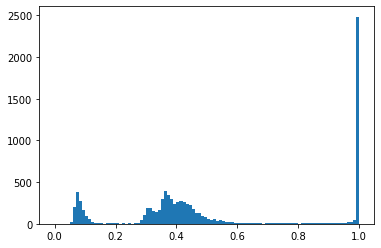

In [47]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [48]:
#%debug

In [49]:
#=====

# Predict and submit

In [50]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    preds = []
    for i, (images, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images)
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
    
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return predictions

In [51]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None):
    model = eval(CFG.model_cls)()
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    is_add_ch=CFG.is_add_ch,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    for pth in pths:
        print("pth:", pth)
        
        # inference
        if predictions is None:
            predictions = inference(model, pth, test_loader, device, tta_transforms)
        else:
            predictions += inference(model, pth, test_loader, device, tta_transforms)

    test['preds'] = predictions / len(pths)
    
    return test

In [52]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [53]:
## ==========================================================
## valid inference
## ==========================================================
#seed = CFG.seeds[0]
#valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")
#
## tta inference
#pred_valid = pd.DataFrame()
#for fold in CFG.trn_fold:
#    print(f"===== valid fold{fold} =====")
#    
#    # model pths
#    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
#    print(pths)
#    
#    valid_f = valid[valid.fold == fold]
#    print(valid_f.shape)
#    
#    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#    
#    ## =============================
#    ## tta alb
#    ## =============================
#    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
#    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
#    #
#    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
#    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
#    ## =============================
#    
#    ## =============================
#    ## tta Dataset
#    ## =============================
#    #_test_dataset = TrainDataset(valid_f, 
#    #                             transforms=get_transforms(data="valid"),
#    #                             prob_spec_start_random=1.0,
#    #                             #prob_vshift=1.0,
#    #                             is_npy=CFG.is_npy,
#    #                             is_add_ch=CFG.is_add_ch,
#    #                           )
#    #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
#    #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
#    #
#    #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
#    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
#    ## =============================
#    
#    _ = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
#    pred_valid = pd.concat([pred_valid, valid_f])
#    
#tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
#pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
#display(pred_valid.head())
#
##if CFG.is_wandb:
##    # save log wandb
##    wandb.log({f"TTA oof Score": tta_oof_score})

['/volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:14<00:00, 16.81it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold1_seed0_best_score.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:14<00:00, 17.09it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold2_seed0_best_score.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:14<00:00, 17.05it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold3_seed0_best_score.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:14<00:00, 17.19it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma/3090_kqi_ex066_public_add_ex003_2-005-01_005iso-01_006_fold01234_b5_ap_largekernel_p-robustscaler_ts-ma_fold4_seed0_best_score.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:14<00:00, 17.17it/s]


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.329932   
1  1.248537e+09         42746.0  0.491669   
2  1.248567e+09         55878.0  0.319171   
3  1.248537e+09         48020.0  0.370180   
4  1.248543e+09         45246.0  0.377170   

                                                path   h1_mean   l1_mean  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...  2.251338  2.247327   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...  2.250531  2.253083   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...  2.249787  2.250360   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...  2.251309  2.250812   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...  2.250533  2.250065   

     h1_std    l1_std     preds  
0  0.397542  0.397476  0.329932  
1  0.399520  0.399918  0.491669  
2  0.399082  0.401004  0.319171  
3  0.399954  0.399532  0.370180  
4  0.402394  0.400455  0.377170

target range [0.274250, 1.000000]


id    target
0  00054c878  0.329932
1  0007285a3  0.491669
2  00076c5a6  0.319171
3  001349290  0.370180
4  001a52e92  0.377170

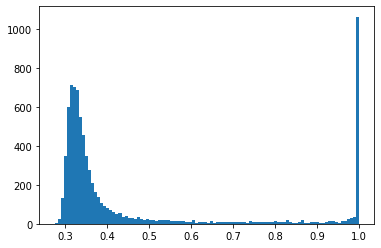

In [54]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)

    # ==========================================================
    # test inference
    # ==========================================================
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit.head())

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [55]:
if CFG.is_wandb:
    wandb.finish()